#MOGP LMC/ICM

In [1]:
import os
from pathlib import Path 
import sys

os.environ['SUMO_HOME'] = '/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'
os.environ['LIBSUMO_AS_TRACI'] = '1' #Optional: for a huge performance boost (~8x) with Libsumo (No GUI)
SUMO_HOME = Path(os.environ['SUMO_HOME'])

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")
#import traci

# Add the SUMO *bin* directory to PATH so od2trips/duarouter/sumo are found
# Your SUMO_HOME is .../EclipseSUMO/share/sumo → bin is two levels up, then /bin
SUMO_ROOT = Path(os.environ["SUMO_HOME"]).parents[1]          # .../EclipseSUMO
SUMO_BIN  = str(SUMO_ROOT / "bin") # this convert path to /EclipseSUMO/bin
LIB_SUMO_PATH = Path(os.environ["SUMO_HOME"]).parents[2] / "lib" / "libsumo.dylib"

os.environ["PATH"] = SUMO_BIN + os.pathsep + os.environ.get("PATH", "")

import traci
import sumolib
import json, shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import seaborn as sns
import torch
from torch.quasirandom import SobolEngine

from botorch import fit_gpytorch_mll
from botorch.acquisition import qLogExpectedImprovement
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.utils.transforms import unnormalize, normalize

from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize


base_path = Path("/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn")


if str(base_path ) not in sys.path:
    sys.path.insert(0, str(base_path ))

os.chdir(base_path )

from helpers_od_calibration_BN import load_kwargs_config
from src.simulation.data_loader import od_xml_to_df
from src.simulation.evaluation import parse_loop_data_xml_to_pandas
from src.simulation.sumo_runner import create_taz_xml, simulate_od
from src.utils.link_flow_analysis import (
    compute_squared_metric_all_edge as compute_nrmse_counts_all_edges,
    compute_squared_metric_per_edge as compute_nrmse_per_edge,
)
%matplotlib inline


config = load_kwargs_config(base_path, "bo_vanilla")
Path(config["simulation_run_path"]).mkdir(parents=True, exist_ok=True)
pprint.pprint(dict(config))

/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo/tools/traci/__init__.py:42: UserWarning: Could not import libsumo using /Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/bin/python, falling back to pure python traci (No module named 'libsumo').
  warnings.warn("Could not import libsumo using %s, falling back to pure python traci (%s)." %


{'BATCH_SIZE': 1,
 'EDGE_OUT_STR': 'edge_data_quickstart.xml',
 'NITER': 10,
 'NUM_RESTARTS': 5,
 'RAW_SAMPLES': 32,
 'SAMPLE_SHAPE': 128,
 'SUMO_PATH': PosixPath('/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'),
 'TRIPS2ODS_OUT_STR': 'trips.xml',
 'additional_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml'),
 'file_gt_od': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/od.xml'),
 'fixed_routes': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/routes.csv'),
 'model_name': 'bo_vanilla',
 'n_init_search': 20,
 'net_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml'),
 'network_name': 'quickstart',
 'network_path': PosixPath('network/quickstart'),
 'od_duration_sec': 300,
 'sim_end_time': 57600,
 'sim_start_time': 54000,
 'sim_stat_freq_sec': 300,
 'simulation_run_path': 'output/quickstart_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# create GT scenario 

In [2]:
# Get Ground Truth OD + fixed routes
print(f"Reading: {config['file_gt_od']}")
gt_od_df = od_xml_to_df(config["file_gt_od"])

print(f"Reading: {config['fixed_routes']}")
routes_df = pd.read_csv(config["fixed_routes"], index_col=0)



Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/od.xml
Total GT demand: 2800.0
Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/routes.csv


In [3]:
simulation_gt_run_path =f'{config["simulation_run_path"]}/ground_truth'
prefix_output_gt = f'{simulation_gt_run_path}/sim'
sim_edge_out_gt = f'{prefix_output_gt}_{config["EDGE_OUT_STR"]}'
new_od_xml = f'{simulation_gt_run_path}/od.xml'

Path(simulation_gt_run_path).mkdir(parents=True, exist_ok=True)

base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()
curr_od = gt_od_vals.copy()
base_od['count'] = curr_od
base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})
create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)

print(base_od)


# Run simulation
simulate_od(new_od_xml,
            prefix_output_gt,
            base_path,
            config["net_xml"],
            config["taz2edge_xml"],
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"])

Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/ground_truth/od.xml
    from     to  count
0  taz91  taz93  500.0
1  taz91  taz94  500.0
2  taz92  taz93  900.0
3  taz92  taz94  900.0
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/ground_truth/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/ground_truth/sim_trips_beforeRteUpdates.xml
Success.time 299.17
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/ground_truth/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/ground_truth/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --du

In [4]:
df_edge_gt, df_trips_raw, out_csv = parse_loop_data_xml_to_pandas(
    base_path,
    sim_edge_out_gt,   # '.../ground_truth/sim_edge_data_quickstart.xml'
    prefix_output_gt,  # '.../ground_truth/sim'
    config["SUMO_PATH"],
)

print(df_edge_gt.head())
print(df_trips_raw.columns)

num_gt_edges = df_edge_gt.shape[0]
print("Number of GT edges:",num_gt_edges)


  edge_id  interval_nVehContrib  interval_harmonicMeanSpeed
0      D2                1000.0                    8.445000
1      D4                1800.0                    8.527143
2      D5                1400.0                   11.488750
3      D7                1400.0                   11.294444
4     L10                1400.0                   11.441250
Index(['interval_begin', 'interval_end', 'interval_id', 'edge_arrived',
       'edge_density', 'edge_departed', 'edge_entered', 'edge_id',
       'edge_laneChangedFrom', 'edge_laneChangedTo', 'edge_laneDensity',
       'edge_left', 'edge_occupancy', 'edge_overlapTraveltime',
       'edge_sampledSeconds', 'edge_speed', 'edge_speedRelative',
       'edge_timeLoss', 'edge_traveltime', 'edge_waitingTime',
       'interval_nVehContrib', 'interval_harmonicMeanSpeed'],
      dtype='object')
Number of GT edges: 14


In [5]:
print(num_gt_edges)

14


In [6]:
print(df_trips_raw.columns)


#edge_speed', 'edge_speedRelative','edge_timeLoss', 'edge_traveltime', 'edge_waitingTime','interval_nVehContrib', 'interval_harmonicMeanSpeed'

#other objectives

Index(['interval_begin', 'interval_end', 'interval_id', 'edge_arrived',
       'edge_density', 'edge_departed', 'edge_entered', 'edge_id',
       'edge_laneChangedFrom', 'edge_laneChangedTo', 'edge_laneDensity',
       'edge_left', 'edge_occupancy', 'edge_overlapTraveltime',
       'edge_sampledSeconds', 'edge_speed', 'edge_speedRelative',
       'edge_timeLoss', 'edge_traveltime', 'edge_waitingTime',
       'interval_nVehContrib', 'interval_harmonicMeanSpeed'],
      dtype='object')


In [7]:
print(df_edge_gt.columns)

Index(['edge_id', 'interval_nVehContrib', 'interval_harmonicMeanSpeed'], dtype='object')


In [8]:
print(df_edge_gt.head())

  edge_id  interval_nVehContrib  interval_harmonicMeanSpeed
0      D2                1000.0                    8.445000
1      D4                1800.0                    8.527143
2      D5                1400.0                   11.488750
3      D7                1400.0                   11.294444
4     L10                1400.0                   11.441250


In [9]:
gt_edge_data = df_edge_gt.sort_values(by=['interval_nVehContrib'], ascending=False).iloc[:num_gt_edges] # 14 


print(sim_edge_out_gt)

edge_ids = gt_edge_data["edge_id"].tolist()

gt_flows = (gt_edge_data.set_index("edge_id") # set index makes the edges IDs the dataframe index 
.loc[edge_ids, "interval_nVehContrib"]  #.loc[edge_ids, ...] = "Select rows where the index is in the edge_ids list and the col "interval_nVehContrib"
.values.astype(float)
) # gt_flow is a numpy array which is a vector of the flows on the edges 


L = len(edge_ids) # number of edges, 14
weights_np = np.ones(L) / L    # [1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L, 1/L] with L= 14 
#  np.ones(L) Create a 1-dimensional array of length L with all elements equal to 1, and then each element of the array is divided by L to get the weights.

print("Using UNIFORM weights:")
for e, w in zip(edge_ids, weights_np):
    print(f"  {e}: weight = {w:.4f}")

output/quickstart_bo_vanilla/ground_truth/sim_edge_data_quickstart.xml
Using UNIFORM weights:
  D4: weight = 0.0714
  L14: weight = 0.0714
  L4: weight = 0.0714
  D5: weight = 0.0714
  D7: weight = 0.0714
  L10: weight = 0.0714
  L18: weight = 0.0714
  L5: weight = 0.0714
  L7: weight = 0.0714
  D2: weight = 0.0714
  L12: weight = 0.0714
  L2: weight = 0.0714
  L16: weight = 0.0714
  L15: weight = 0.0714


In [10]:
print(gt_flows)

[1800. 1800. 1800. 1400. 1400. 1400. 1400. 1400. 1400. 1000. 1000. 1000.
  900.  500.]


In [11]:
print ("GT flows :", gt_flows[:])
print ("Weights :", weights_np[:])

GT flows : [1800. 1800. 1800. 1400. 1400. 1400. 1400. 1400. 1400. 1000. 1000. 1000.
  900.  500.]
Weights : [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857]


# sobol points 

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.double

dim_od = gt_od_df.shape[0] # dimension of the od vector
print(dim_od)

bounds = torch.tensor([
    [ 0 for _ in range(dim_od)],
    [ 2000 for _ in range(dim_od)]
], device=device, dtype=dtype)  # this is bound for the initial trainig points (od vector)



seed = 42  

torch.manual_seed(seed)

np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

print(f"Random seed set to {seed}")



sobol = SobolEngine(dim_od, scramble=True, seed = seed)
#using seed for reproducibility
x_0 = sobol.draw(config["n_init_search"]).to(dtype=dtype).to(device)
print (x_0.shape)

# map the normalized into the original parameter space
train_X0 = unnormalize(x_0, bounds)

print (train_X0) 
print (dim_od)

cpu
4
Random seed set to 42
torch.Size([20, 4])
tensor([[1995.0267,  208.7328, 1645.9577,  838.8643],
        [ 905.4018, 1676.1346,  146.5409, 1232.3399],
        [ 436.3676,  700.4452, 1395.8535,  347.9317],
        [1463.9845, 1168.5940,  896.6126, 1706.4115],
        [1172.4651,  780.6038,  309.8300, 1819.2374],
        [ 208.3256, 1373.7338, 1810.7880,  236.2808],
        [ 738.9139,  257.4842,  559.9794, 1367.4970],
        [1642.0144, 1849.8973, 1060.6097,  702.4102],
        [1538.6412,  590.4874,  634.4098,  101.0750],
        [ 564.7905, 1059.8532, 1135.5953, 1953.6954],
        [  97.3469,   66.7411,  384.3306,  587.1246],
        [1006.2524, 1536.8247, 1885.7071, 1482.5537],
        [1357.3130,  396.7292, 1282.7886, 1120.7016],
        [ 257.9750, 1991.8317,  784.0896,  949.7550],
        [ 790.8787,  889.4018, 1532.9441, 1567.5589],
        [1824.3027, 1483.7563,   33.9629,  486.5554],
        [1770.7187,  937.5904, 1217.8479, 1300.8279],
        [ 860.3464, 1408.1616,  71

## evaluation of Sobol points

In [13]:
csv_path = Path(f"{config['simulation_run_path']}/initial_search/data_set_ods_icm_replicated.csv")

# Check if initial data already exists
if csv_path.exists():
    print(f"✓ Loading initial data from {csv_path}")
    df_initial = pd.read_csv(csv_path)
    
    # Extract data from CSV
    train_X_list = []
    train_E_list = []
    S_list = []
    
    # Get x_* columns (OD inputs) - sorted by number
    x_cols = [col for col in df_initial.columns if col.startswith('x_')]
    x_cols.sort(key=lambda x: int(x.split('_')[1]))
    
    # Get e_* columns (per-edge errors)
    e_cols = [col for col in df_initial.columns if col.startswith('e_')]
    
    # Load each row
    for idx, row in df_initial.iterrows():
        train_X_list.append(row[x_cols].values.astype(float))
        train_E_list.append(row[e_cols].values.astype(float))
        S_list.append(float(row['loss']))
    
    print(f"  Loaded {len(train_X_list)} initial points")
    print(f"  OD dimension: {len(x_cols)}, Edges: {len(e_cols)}")
    
else:
    print(f"✗ CSV not found. Running {config['n_init_search']} initial simulations...")
    
    train_X_list = []      # each: np.array, shape [dim_od]
    train_E_list = []      # each: np.array, shape [L] (per-edge errors)
    S_list       = []      # each: scalar aggregated loss

    batch_data_i = []      # for CSV / plotting
    N_REP = 1           

    for i, x in enumerate(train_X0.tolist()):
        print(f"Initial OD: {i}")
        curr_od = np.array(x, dtype=float)
        print(curr_od)
        print(f"total expected demand: {np.sum(curr_od)}")


        simulation_run_path_init = f"{config['simulation_run_path']}/initial_search"
        Path(simulation_run_path_init).mkdir(parents=True, exist_ok=True)

        # OD xml for this candidate (same for all reps)
        new_od_xml = f"{simulation_run_path_init}/gt_od_{config['network_name']}_{i}.xml"
        prefix_output_base = f"{simulation_run_path_init}/sobol_{i}"

        
        base_od = gt_od_df.copy() 
        base_od["count"] = curr_od
        base_od["count"] = [round(v, 1) for v in base_od["count"]]
        base_od = base_od.rename(columns={"fromTaz": "from", "toTaz": "to"})
        create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path)

        
        per_edge_errors_reps = []

        for rep in range(N_REP):
            print(f"    ▶ Replication {rep}")
            prefix_output_rep = f"{prefix_output_base}_rep{rep}"

            simulate_od(
                new_od_xml,
                prefix_output_rep,
                base_path,
                config["net_xml"],
                config["taz2edge_xml"],
                config["additional_xml"],
                routes_df,
                config["sim_end_time"],
                config["TRIPS2ODS_OUT_STR"],
                sim_start_time=0,
                seed=rep,   # different seed per replication
            )

            sim_edge_out_rep = f"{prefix_output_rep}_{config['EDGE_OUT_STR']}"
            curr_loop_stats_rep, _, _ = parse_loop_data_xml_to_pandas(
                base_path,
                sim_edge_out_rep,
                prefix_output_rep,
                config["SUMO_PATH"],
            )

            # printing simulated flows per edge 
            sim_counts = (
                curr_loop_stats_rep[curr_loop_stats_rep["edge_id"].isin(edge_ids)]
                .set_index("edge_id")["interval_nVehContrib"]
                .loc[edge_ids]  # preserve order
                .values
            )

            print(f"\n--- Simulated flows for replication {rep} ---")
            for edge_id, count in zip(edge_ids, sim_counts):
                print(f"  {edge_id}: {count}")

            # per-edge error for this replication (e_l(x))
            per_edge_errors_rep = compute_nrmse_per_edge(
                df_true=gt_edge_data,
                df_simulated=curr_loop_stats_rep,
                edge_ids=edge_ids,
            )  # np.array [L]

            per_edge_errors_reps.append(per_edge_errors_rep)

        
        per_edge_errors_reps = np.stack(per_edge_errors_reps, axis=0)  # [N_REP, L]
        per_edge_errors = per_edge_errors_reps.mean(axis=0)            # [L]

        # aggregated scalar loss S(x) = Σ_l w_l e_l(x)
        S_x = float((per_edge_errors * weights_np).sum())
        print(f"aggregated loss S(x): {S_x}")

        
        train_X_list.append(curr_od.copy())
        train_E_list.append(per_edge_errors.copy())
        S_list.append(S_x)

        
        df_curr = pd.DataFrame(
            curr_od.reshape(1, -1),
            columns=[f"x_{k+1}" for k in range(curr_od.shape[0])]
        )
        df_curr["loss"] = S_x
        
        # Add per-edge errors as columns (e_edge_id for each edge)
        for edge_idx, edge_id in enumerate(edge_ids):
            df_curr[f"e_{edge_id}"] = per_edge_errors[edge_idx]
        
        batch_data_i.append(df_curr)

    # Save initial dataset
    df_initial_bo = pd.concat(batch_data_i, ignore_index=True)
    df_initial_bo.to_csv(csv_path, index=False)
    print(f"✓ Saved initial data to {csv_path}")

✓ Loading initial data from output/quickstart_bo_vanilla/initial_search/data_set_ods_icm_replicated.csv
  Loaded 20 initial points
  OD dimension: 4, Edges: 14


In [14]:
print (S_list )
print (train_X_list)

[1.5431797909153078, 0.8662538000215959, 0.0661608171903682, 1.275962487744304, 0.5627743271424971, 0.1864039238383183, 0.0434194783500701, 2.0360066192635786, 0.8334976954612531, 0.587408248749235, 0.4031089462261095, 1.3064210696109129, 0.5295852875139474, 0.6260342739085053, 0.4905883014433285, 1.8242497358816536, 1.4887928176942733, 0.4494707504229204, 0.4911170025915128, 1.4529777107943709]
[array([1995.02670765,  208.73278379, 1645.95770836,  838.86432648]), array([ 905.4017663 , 1676.13458633,  146.54093981, 1232.33985901]), array([ 436.36757135,  700.44517517, 1395.85351944,  347.93174267]), array([1463.98448944, 1168.59400272,  896.61258459, 1706.4114809 ]), array([1172.46508598,  780.60382605,  309.82995033, 1819.23735142]), array([ 208.32563937, 1373.73375893, 1810.78803539,  236.28084362]), array([ 738.9138937 ,  257.48419762,  559.97943878, 1367.49696732]), array([1642.01438427, 1849.89726543, 1060.6096983 ,  702.4101615 ]), array([1538.64121437,  590.48742056,  634.409785

# ICM CLEAN

# fitting gp 

In [15]:
import torch
import numpy as np
from pathlib import Path
from botorch.utils.transforms import normalize, unnormalize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

from MOGP.helpers_MOGP import initialize_icm_gp, LinearAggregationICM
from MOGP.helpers_MOGP import fit_gpytorch_mll_with_retries

In [16]:
dtype  = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_X_icm = torch.tensor(np.array(train_X_list),
                           dtype=dtype, device=device)   # [N, d]

# Raw per-edge errors meaning no standardization 
train_Y_icm_raw = torch.tensor(np.array(train_E_list),
                               dtype=dtype, device=device)   # [N, L]

# Standardize outputs per edge for GP stability
y_mean = train_Y_icm_raw.mean(dim=0, keepdim=True)
y_std = train_Y_icm_raw.std(dim=0, keepdim=True).clamp_min(1e-6)
train_Y_icm = (train_Y_icm_raw - y_mean) / y_std

N, d = train_X_icm.shape
L    = train_Y_icm.shape[1]

max_demand = 2000.0
bounds = torch.stack([
    torch.zeros(d, dtype=dtype, device=device),
    torch.full((d,), max_demand, dtype=dtype, device=device),
])

train_X_norm = normalize(train_X_icm, bounds=bounds)


icm_model, mll = initialize_icm_gp(train_X_norm, train_Y_icm, rank=3) # gp fitting is on standardize data 

icm_model     = icm_model.to(device=device, dtype=dtype)
icm_model.likelihood = icm_model.likelihood.to(device=device, dtype=dtype)
mll           = mll.to(device=device, dtype=dtype)


weights_uniform = torch.ones(L, dtype=dtype, device=device)
weights_uniform = weights_uniform / weights_uniform.sum()


agg_model = LinearAggregationICM(icm_model, weights_uniform).to(device=device, dtype=dtype)

icm_model.train()
mll.train()

#fit_gpytorch_mll(mll)   


fit_gpytorch_mll_with_retries(mll, max_retries=3, base_jitter=1e-3, jitter_multiplier=10.0, verbose=True)

print("Initial ICM fit done.")

ICM fit successful on attempt 1 (jitter=0.0e+00).
Initial ICM fit done.


# inspecting the inital paramters 

In [17]:
print(train_Y_icm)

tensor([[-0.3796, -0.3796, -0.3796,  3.3480, -0.9402, -0.9402,  3.3480,  3.3480,
         -0.9402, -0.1989, -0.1989, -0.1989, -1.0863,  2.4211],
        [-0.6749, -0.6749, -0.6749, -0.6479,  1.3735,  1.3735, -0.6479, -0.6479,
          1.3735,  0.3723,  0.3723,  0.3723, -0.7480, -0.6250],
        [-0.8509, -0.8509, -0.8509, -0.5951, -0.9402, -0.9402, -0.5951, -0.5951,
         -0.9402, -0.9775, -0.9775, -0.9775, -0.1362, -0.8602],
        [-0.2021, -0.2021, -0.2021,  0.0043,  1.2676,  1.2676,  0.0043,  0.0043,
          1.2676,  0.4633,  0.4633,  0.4633,  0.9579,  0.5006],
        [-0.7447, -0.7447, -0.7447, -0.7418,  0.4714,  0.4714, -0.7418, -0.7418,
          0.4714, -0.4945, -0.4945, -0.4945,  1.5681, -0.2021],
        [-0.7929, -0.7929, -0.7929, -0.4358, -1.0260, -1.0260, -0.4358, -0.4358,
         -1.0260, -0.8033, -0.8033, -0.8033,  0.2938, -0.7409],
        [-0.8375, -0.8375, -0.8375, -0.7389, -1.0185, -1.0185, -0.7389, -0.7389,
         -1.0185, -0.9875, -0.9875, -0.9875, -0.4

In [18]:
print("train_Y shape:", train_Y_icm.shape)            
print("model num_tasks:", icm_model.num_tasks)        
print("likelihood num_tasks:", icm_model.likelihood.num_tasks) 

train_Y shape: torch.Size([20, 14])
model num_tasks: 14
likelihood num_tasks: 14


In [19]:

S_all_raw = (train_Y_icm_raw * weights_uniform).sum(dim=1) 
S_all_std = (train_Y_icm * weights_uniform).sum(dim=1) 

best_S_raw = S_all_raw.min().item()
best_S_std = S_all_std.min().item()

print("Initial S values (raw):", S_all_raw.cpu().numpy())
print(f"Initial best S (raw) = {best_S_raw:.6f}")
print(f"Initial best S (std) = {best_S_std:.6f}")

S_history_raw     = [best_S_raw]
S_obs_history_raw = S_all_raw.cpu().tolist()
S_history_std     = [best_S_std]


Initial S values (raw): [1.5431798  0.86625385 0.06616082 1.2759625  0.56277436 0.18640393
 0.04341948 2.0360067  0.83349776 0.5874083  0.40310895 1.306421
 0.52958536 0.6260343  0.49058837 1.8242497  1.4887929  0.44947076
 0.49111703 1.4529779 ]
Initial best S (raw) = 0.043419
Initial best S (std) = -0.852600


In [20]:

#ONE BO ITERATION


print("\n BO ITERATION")

# Put model in eval mode
icm_model.eval()
agg_model.eval()


EI = ExpectedImprovement(
    model=agg_model,
    best_f=best_S_std,
    maximize=False
)


bounds_norm = torch.stack([
    torch.zeros(d, dtype=dtype, device=device),
    torch.ones(d,  dtype=dtype, device=device),
])


#acquisition
x_next_norm, acq_val = optimize_acqf(
    EI,
    bounds=bounds_norm, # search space constraint between 0 and 1
    q=1, # batch 
    num_restarts=config["NUM_RESTARTS"],
    raw_samples=config["RAW_SAMPLES"],
)

x_next_norm = x_next_norm.detach()

with torch.no_grad():
    post = agg_model.posterior(x_next_norm)
    mu_next = post.mean.item()
    std_next = post.variance.sqrt().item()

print(f"[ACQ] x_next_norm = {x_next_norm.cpu().numpy()}")
print(f"[ACQ] Predicted S = {mu_next:.4f} ± {std_next:.4f}")

# Convert to REAL OD (0..2000)
x_next_real = unnormalize(x_next_norm, bounds).view(-1).cpu().numpy()
print(f"[ACQ] x_next (real scale) = {x_next_real}")


 BO ITERATION
[ACQ] x_next_norm = [[0.        0.5691059 0.        0.       ]]
[ACQ] Predicted S = -0.5111 ± 0.1355
[ACQ] x_next (real scale) = [   0.     1138.2118    0.        0.    ]


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


In [21]:
from pathlib import Path
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from MOGP.helpers_MOGP import fit_gpytorch_mll_with_retries
from src.utils.seed import set_seed
import numpy as np


N_init, d      = train_X_icm.shape
L              = train_Y_icm.shape[1]

N_RESTARTS = 1
N_BO_ITERS = 100

bounds_norm = torch.stack([
    torch.zeros(d, dtype=dtype, device=device),
    torch.ones(d,  dtype=dtype, device=device),
])


weights_uniform = torch.ones(L, device=device, dtype=dtype)
weights_uniform = weights_uniform / weights_uniform.sum()

train_X_icm_init = train_X_icm.clone()
train_Y_icm_raw_init = train_Y_icm_raw.clone()

icm_histories_raw = []
icm_histories_std = []

for r in range(N_RESTARTS):
    print(f"\n\n============================")
    print(f"      ICM RESTART {r+1}/{N_RESTARTS}")
    print("============================\n")
    
    
    seed = 42 + r
    set_seed(seed)
    print(f"[SEED] Set seed to {seed} for restart {r+1}")

    # Reset data to initial samples
    train_X_icm = train_X_icm_init.clone()
    train_Y_icm_raw = train_Y_icm_raw_init.clone()

    # Standardize outputs per edge (fixed stats per restart)
    y_mean = train_Y_icm_raw.mean(dim=0, keepdim=True)
    y_std = train_Y_icm_raw.std(dim=0, keepdim=True).clamp_min(1e-6)
    train_Y_icm = (train_Y_icm_raw - y_mean) / y_std

    # Normalize inputs
    train_X_norm = normalize(train_X_icm, bounds=bounds)

    # Init ICM model
    icm_model, mll = initialize_icm_gp(train_X_norm, train_Y_icm, rank=3)
    icm_model = icm_model.to(device=device, dtype=dtype)
    icm_model.likelihood = icm_model.likelihood.to(device=device, dtype=dtype)
    mll = mll.to(device=device, dtype=dtype)

    agg_model = LinearAggregationICM(icm_model, weights_uniform).to(device=device, dtype=dtype)

    # Initial best S
    S_all_raw = (train_Y_icm_raw * weights_uniform).sum(dim=1) 
    S_all_std = (train_Y_icm * weights_uniform).sum(dim=1) 

    best_S_raw = S_all_raw.min().item()
    best_S_std = S_all_std.min().item()

    S_history_raw = [best_S_raw]
    S_history_std = [best_S_std]
    S_obs_history_raw = S_all_raw.detach().cpu().tolist()

    # BO LOOP
    for it in range(N_BO_ITERS):
        print("\n\n============================")
        print(f"       ICM BO ITER {it+1}/{N_BO_ITERS}")
        print("============================\n")

        icm_model.eval()
        agg_model.eval()

        EI = ExpectedImprovement(
            model=agg_model,
            best_f=best_S_std,
            maximize=False,  
        )

        x_next_norm, acq_val = optimize_acqf(
            EI,
            bounds=bounds_norm,
            q=1,
            num_restarts=config["NUM_RESTARTS"],
            raw_samples=config["RAW_SAMPLES"],
        )
        x_next_norm = x_next_norm.detach()

        with torch.no_grad():
            post_next = agg_model.posterior(x_next_norm)
            mu_next   = post_next.mean.item()
            std_next  = post_next.variance.sqrt().item()

        print(f"[ACQ] EI value = {acq_val.item():.6f}")
        print(f"[ACQ] x_next_norm = {x_next_norm.cpu().numpy()}")
        print(f"[ACQ] Predicted S(x_next) ≈ {mu_next:.6f} ± {std_next:.6f}")

        # Map to REAL OD space
        x_next_real = (
            unnormalize(x_next_norm, bounds)
            .view(-1)
            .cpu()
            .numpy()
        )
        print(f"[ACQ] Candidate OD (real space) = {x_next_real}")
        print(f"[ACQ] Total demand = {x_next_real.sum():.2f}")

        # SUMO
        sim_dir = f"{config['simulation_run_path']}/icm_bo_restart_{r}/iter_{it}"
        Path(sim_dir).mkdir(parents=True, exist_ok=True)

        new_od_xml    = f"{sim_dir}/od.xml"
        prefix_output = f"{sim_dir}/sim"

        base_od = gt_od_df.copy()
        base_od["count"] = x_next_real
        base_od = base_od.rename(columns={"fromTaz": "from", "toTaz": "to"})

        create_taz_xml(
            new_od_xml,
            base_od,
            config["od_duration_sec"],
            base_path,
        )

        simulate_od(
            new_od_xml,
            prefix_output,
            base_path,
            config["net_xml"],
            config["taz2edge_xml"],
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"],
        )

        print("\nOD COMPARISON")
        gt_od  = gt_od_df['count'].astype(float).values
        sim_od = x_next_real
        for idx, (gt_val, sim_val) in enumerate(zip(gt_od, sim_od)):
            print(f"  OD pair {idx:02d}: GT = {gt_val:8.2f}   SIM = {sim_val:8.2f}")
        print("Total GT demand :", gt_od.sum())
        print("Total SIM demand:", sim_od.sum())
        print("================================================\n")

        # Per-edge errors
        sim_edge_out = f"{prefix_output}_{config['EDGE_OUT_STR']}"
        curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(
            base_dir=base_path,
            sim_edge_file=sim_edge_out,
            prefix_output=prefix_output,
            SUMO_PATH=config["SUMO_PATH"],
        )

        e_next = compute_nrmse_per_edge(
            df_true=gt_edge_data,
            df_simulated=curr_loop_stats,
            edge_ids=edge_ids,
        )

        e_next_tensor = torch.tensor(e_next, device=device, dtype=dtype)
        e_next_std = (e_next_tensor - y_mean) / y_std

        print("\n[SIM] Per-edge errors e_next:")
        for eid, e_val in zip(edge_ids, e_next):
            print(f"  edge {eid}: e = {e_val:.6f}")

        # Aggregated S
        S_next_raw = (e_next_tensor * weights_uniform).sum()
        S_next_std = (e_next_std * weights_uniform).sum()
        S_next_val = S_next_raw.item()
        print(f"[SIM] S(x_next) = {S_next_val:.6f}")

        S_obs_history_raw.append(S_next_val)

        # Update training data
        train_X_icm = torch.cat(
            [train_X_icm,
             torch.tensor(x_next_real, device=device, dtype=dtype).view(1, -1)],
            dim=0,
        )
        train_Y_icm_raw = torch.cat(
            [train_Y_icm_raw, e_next_tensor.view(1, -1)],
            dim=0,
        )
        train_Y_icm = torch.cat(
            [train_Y_icm, e_next_std.view(1, -1)],
            dim=0,
        )

        train_X_norm = normalize(train_X_icm, bounds=bounds)

        # Refit ICM GP
        icm_model, mll = initialize_icm_gp(train_X_norm, train_Y_icm, rank=3)
        icm_model = icm_model.to(device=device, dtype=dtype)
        icm_model.likelihood = icm_model.likelihood.to(device=device, dtype=dtype)
        mll = mll.to(device=device, dtype=dtype)

        agg_model = LinearAggregationICM(icm_model, weights_uniform).to(device=device, dtype=dtype)

        icm_model.train()
        mll.train()
        fit_gpytorch_mll_with_retries(
            mll,
            max_retries=3,
            base_jitter=1e-3,
            jitter_multiplier=10.0,
            verbose=True,
        )

    
        if S_next_val < best_S_raw:
            print(f"[UPDATE] New BEST S (raw): {S_next_val:.6f} (previous {best_S_raw:.6f})")
            best_S_raw = S_next_val
        else:
            print(f"[NO IMPROVEMENT] Best raw remains = {best_S_raw:.6f}")

        if S_next_std.item() < best_S_std:
            best_S_std = S_next_std.item()

        S_history_raw.append(best_S_raw)
        S_history_std.append(best_S_std)

    icm_histories_raw.append(S_history_raw)
    icm_histories_std.append(S_history_std)

# Mean curve across restarts (raw)
min_len = min(len(h) for h in icm_histories_raw)
S_history_raw = np.mean([h[:min_len] for h in icm_histories_raw], axis=0).tolist()

print("\nFinished ICM BO.")
print(f"Final best S (raw, mean) = {S_history_raw[-1]:.6f}")



      ICM RESTART 1/1

[SEED] Set seed to 42 for restart 1


       ICM BO ITER 1/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.14081794 0.12130647 0.703803   0.06208524]]
[ACQ] Predicted S(x_next) ≈ -0.205265 ± 0.100275
[ACQ] Candidate OD (real space) = [ 281.6359   242.61295 1407.606    124.17048]
[ACQ] Total demand = 2056.03
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_0/sim_trips_beforeRteUpdates.xml


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.47
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_0/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_0/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_0/s

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` wit

[ACQ] EI value = 0.201321
[ACQ] x_next_norm = [[0.         0.6812797  0.59115034 0.        ]]
[ACQ] Predicted S(x_next) ≈ -1.006736 ± 0.266979
[ACQ] Candidate OD (real space) = [   0.     1362.5594 1182.3007    0.    ]
[ACQ] Total demand = 2544.86
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_1/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_1/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_1/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_1/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_2/sim_trips.xml'
Loading done.
Simulation version 1.24.0 started with time: 0.00.
Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 4603 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 1.34s
 Real time factor: 43113.8
 UPS: 1457616.766467
Vehicles:
 Inserted: 4603
 Running: 0
 Waiting: 0
Statistics (avg of 4603):
 RouteLength: 4500.18
 Speed: 10.66
 Duration: 423.07
 WaitingTime: 0.34
 TimeLoss: 94.50
 DepartDelay: 1140.76
DijkstraRouter answered 9062 queries and explored 11.11 edges on average.
Dijkst

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.082658
[ACQ] x_next_norm = [[0.27477178 0.         0.         1.        ]]
[ACQ] Predicted S(x_next) ≈ -0.625371 ± 0.434410
[ACQ] Candidate OD (real space) = [ 549.5436    0.        0.     2000.    ]
[ACQ] Total demand = 2549.54
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_3/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_3/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_3/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_4/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_4/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_4/sim_trips.xml'
Loadin

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.001817
[ACQ] x_next_norm = [[0.8565171 0.        0.        1.       ]]
[ACQ] Predicted S(x_next) ≈ -0.439262 ± 0.208148
[ACQ] Candidate OD (real space) = [1713.0342    0.        0.     2000.    ]
[ACQ] Total demand = 3713.03
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/outpu

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`

ICM fit failed on attempt 3 (jitter=1.0e-02): All attempts to fit the model have failed.
ICM fit failed after all retry attempts.
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 7/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.10943696 0.21022993 0.6757443  0.05058708]]
[ACQ] Predicted S(x_next) ≈ -0.408172 ± 0.097768
[ACQ] Candidate OD (real space) = [ 218.87392   420.45987  1351.4886    101.174164]
[ACQ] Total demand = 2092.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_6/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_6/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_6/sim_trips_beforeRteUpdates.xml
Success.time 299.89
Running SUMO: sumo --output-prefix output/quickstart_bo_van

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 8/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000656
[ACQ] x_next_norm = [[0.6651031  0.         0.         0.54386693]]
[ACQ] Predicted S(x_next) ≈ -0.606594 ± 0.114631
[ACQ] Candidate OD (real space) = [1330.2062    0.        0.     1087.7339]
[ACQ] Total demand = 2417.94
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_7/sim_trips_beforeRteUpdates.xml
Success.time 298.98
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.002853
[ACQ] x_next_norm = [[0.3365486 0.5449946 0.        0.       ]]
[ACQ] Predicted S(x_next) ≈ -0.652315 ± 0.124651
[ACQ] Candidate OD (real space) = [ 673.09717 1089.9891     0.         0.     ]
[ACQ] Total demand = 1763.09
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_8/sim_trips_beforeRteUpdates.xml
Success.time 299.59
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 2753 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.57s
 Real time factor: 101408
 UPS: 2030329.225352
Vehicles:
 Inserted: 2753
 Running: 0
 Waiting: 0
Statistics (avg of 2753):
 RouteLength: 4479.30
 Speed: 10.71
 Duration: 418.90
 WaitingTime: 0.37
 TimeLoss: 91.64
 DepartDelay: 632.81
DijkstraRouter answered 5339 queries and explored 11.04 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).

OD COMPARISON
  OD pair 00: GT =   500.00   SIM =   845.22
  OD pair 01: GT =   500.00   SIM =   741.95
  OD pair 02: GT =   900.00   SIM =   580.77
  OD pair 03: GT =   900.00   SIM =   586.63
Total GT demand : 2800.0
Total SIM demand: 2754.5679


[SIM] Per-edge errors e_next:
  edge D4: e = 0.124060
  edge L14: e = 0.124060
  edge L4: e = 0.124060
  edge D5: e = 0.000319
  edge D7: e = 0.002645
  edge L10: e = 

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.043419


       ICM BO ITER 11/100

[ACQ] EI value = 0.029389
[ACQ] x_next_norm = [[0.         0.4762677  0.7327453  0.21240027]]
[ACQ] Predicted S(x_next) ≈ -0.859569 ± 0.062326
[ACQ] Candidate OD (real space) = [   0.       952.5354  1465.4906   424.80054]
[ACQ] Total demand = 2842.83
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_10/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_10/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_10/sim_trips_beforeRteUpdates.xml
Success.time 299.08
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.059009
[ACQ] x_next_norm = [[0.         0.44485548 1.         0.        ]]
[ACQ] Predicted S(x_next) ≈ -0.702378 ± 0.299229
[ACQ] Candidate OD (real space) = [   0.       889.71094 2000.         0.     ]
[ACQ] Total demand = 2889.71
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_11/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.035306
[ACQ] x_next_norm = [[0.         0.46424255 0.14440727 0.43966672]]
[ACQ] Predicted S(x_next) ≈ -0.817571 ± 0.127172
[ACQ] Candidate OD (real space) = [  0.      928.4851  288.81454 879.33344]
[ACQ] Total demand = 2096.63
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_12/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_12/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_12/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

[ACQ] EI value = 0.045596
[ACQ] x_next_norm = [[0.21129712 0.26190946 0.48813483 0.45597333]]
[ACQ] Predicted S(x_next) ≈ -0.861641 ± 0.104444
[ACQ] Candidate OD (real space) = [422.59424 523.8189  976.26965 911.94666]
[ACQ] Total demand = 2834.63
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_13/sim_trips_beforeRteUpdates.xml
Success.time 298.92
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.002978 (previous 0.043419)


       ICM BO ITER 15/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.01596356 0.12994483 0.78872836 0.06031317]]
[ACQ] Predicted S(x_next) ≈ -0.672181 ± 0.056839
[ACQ] Candidate OD (real space) = [  31.927124  259.88965  1577.4567    120.626335]
[ACQ] Total demand = 1989.90
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_14/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_14/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_14/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_14/sim_ --ignore-route-errors=true --n

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] EI value = 0.000954
[ACQ] x_next_norm = [[0.46117294 0.         0.39861077 0.40456054]]
[ACQ] Predicted S(x_next) ≈ -0.735591 ± 0.096219
[ACQ] Candidate OD (real space) = [922.3459    0.      797.22156 809.1211 ]
[ACQ] Total demand = 2528.69
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_15/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_15/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_15/sim_trips_beforeRteUpdates.xml
Success.time 299.44
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_15/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 17/100

[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.12304374 0.1403244  0.53047496 0.71842575]]
[ACQ] Predicted S(x_next) ≈ -0.661674 ± 0.067261
[ACQ] Candidate OD (real space) = [ 246.08748  280.6488  1060.95    1436.8516 ]
[ACQ] Total demand = 3024.54
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_16/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_16/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_16/sim_trips_beforeRteUpdates.xml
Success.time 299.69
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_16/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 18/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.18795253 0.29767776 0.12225179 0.67576754]]
[ACQ] Predicted S(x_next) ≈ -0.651641 ± 0.061092
[ACQ] Candidate OD (real space) = [ 375.90506  595.3555   244.50359 1351.535  ]
[ACQ] Total demand = 2567.30
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_17/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_17/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_17/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_17/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 19/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.30289063 0.07462467 0.4623016  0.7123114 ]]
[ACQ] Predicted S(x_next) ≈ -0.725953 ± 0.032278
[ACQ] Candidate OD (real space) = [ 605.78125  149.24934  924.6032  1424.6228 ]
[ACQ] Total demand = 3104.26
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_18/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_18/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_18/sim_trips_beforeRteUpdates.xml
Success.time 299.05
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_18/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 20/100

[ACQ] EI value = 0.000002
[ACQ] x_next_norm = [[0.0365908  0.19464728 0.5420089  0.39114425]]
[ACQ] Predicted S(x_next) ≈ -0.743920 ± 0.050946
[ACQ] Candidate OD (real space) = [  73.1816   389.29456 1084.0177   782.2885 ]
[ACQ] Total demand = 2328.78
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_19/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_19/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_19/sim_trips_beforeRteUpdates.xml
Success.time 299.58
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Step #57600.00 (0ms ?*RT. ?UPS, vehicles TOT 3679 ACT 0 BUF 0)                            
Simulation ended at time: 57600.00.
Reason: The final simulation step has been reached.
Performance:
 Duration: 0.86s
 Real time factor: 67132.9
 UPS: 1742976.689977
Vehicles:
 Inserted: 3679
 Running: 0
 Waiting: 0
Statistics (avg of 3679):
 RouteLength: 4321.95
 Speed: 10.64
 Duration: 406.49
 WaitingTime: 0.35
 TimeLoss: 90.77
 DepartDelay: 890.05
DijkstraRouter answered 7210 queries and explored 10.40 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).

OD COMPARISON
  OD pair 00: GT =   500.00   SIM =   931.64
  OD pair 01: GT =   500.00   SIM =  1123.53
  OD pair 02: GT =   900.00   SIM =  1236.07
  OD pair 03: GT =   900.00   SIM =   388.89
Total GT demand : 2800.0
Total SIM demand: 3680.138


[SIM] Per-edge errors e_next:
  edge D4: e = 0.009560
  edge L14: e = 0.009560
  edge L4: e = 0.009560
  edge D5: e = 0.300931
  edge D7: e = 0.006286
  edge L10: e = 

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 22/100

[ACQ] EI value = 0.000033
[ACQ] x_next_norm = [[0.12217865 0.35724613 0.4364172  0.45374966]]
[ACQ] Predicted S(x_next) ≈ -0.822010 ± 0.035775
[ACQ] Candidate OD (real space) = [244.3573  714.49225 872.8344  907.4993 ]
[ACQ] Total demand = 2739.18
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_21/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_21/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_21/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_21/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 23/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.01876135 0.7994075  0.75718594 0.1832007 ]]
[ACQ] Predicted S(x_next) ≈ -0.705788 ± 0.025640
[ACQ] Candidate OD (real space) = [  37.522697 1598.815    1514.3718    366.4014  ]
[ACQ] Total demand = 3517.11
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_22/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_22/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_22/sim_trips_beforeRteUpdates.xml
Success.time 299.34
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_22/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 24/100

[ACQ] EI value = 0.002486
[ACQ] x_next_norm = [[1.        0.        0.        0.6317514]]
[ACQ] Predicted S(x_next) ≈ -0.415194 ± 0.259476
[ACQ] Candidate OD (real space) = [2000.        0.        0.     1263.5028]
[ACQ] Total demand = 3263.50
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_23/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_23/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_23/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/inesbenh

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 25/100

[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.1289548  0.07703527 0.6887547  0.7090243 ]]
[ACQ] Predicted S(x_next) ≈ -0.724420 ± 0.047901
[ACQ] Candidate OD (real space) = [ 257.9096   154.07054 1377.5094  1418.0486 ]
[ACQ] Total demand = 3207.54
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_24/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_24/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_24/sim_trips_beforeRteUpdates.xml
Success.time 299.42
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 26/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.21430613 0.3019993  0.54393303 0.46007636]]
[ACQ] Predicted S(x_next) ≈ -0.866700 ± 0.013428
[ACQ] Candidate OD (real space) = [ 428.61227  603.9986  1087.8661   920.1527 ]
[ACQ] Total demand = 3040.63
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_25/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_25/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_25/sim_trips_beforeRteUpdates.xml
Success.time 299.51
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_25/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 27/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.001054
[ACQ] x_next_norm = [[0.3695991  0.21324377 0.38168198 0.5138903 ]]
[ACQ] Predicted S(x_next) ≈ -0.850183 ± 0.045445
[ACQ] Candidate OD (real space) = [ 739.1982   426.48755  763.36395 1027.7806 ]
[ACQ] Total demand = 2956.83
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_26/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_26/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_26/sim_trips_beforeRteUpdates.xml
Success.time 299.27
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_26/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 28/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.0579311  0.44861147 0.5075929  0.20694505]]
[ACQ] Predicted S(x_next) ≈ -0.807074 ± 0.022622
[ACQ] Candidate OD (real space) = [ 115.862206  897.22296  1015.18585   413.8901  ]
[ACQ] Total demand = 2442.16
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_27/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_27/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_27/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_27/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 29/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.16892649 0.06713182 0.9251191  0.4634798 ]]
[ACQ] Predicted S(x_next) ≈ -0.575015 ± 0.052242
[ACQ] Candidate OD (real space) = [ 337.853    134.26364 1850.2382   926.9596 ]
[ACQ] Total demand = 3249.31
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_28/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_28/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_28/sim_trips_beforeRteUpdates.xml
Success.time 299.56
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_28/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 30/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000205
[ACQ] x_next_norm = [[0.         0.38011968 0.6556712  0.4036815 ]]
[ACQ] Predicted S(x_next) ≈ -0.828396 ± 0.043168
[ACQ] Candidate OD (real space) = [   0.      760.2394 1311.3424  807.363 ]
[ACQ] Total demand = 2878.94
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_29/sim_trips_beforeRteUpdates.xml
Success.time 298.97
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 31/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.4141947  0.09610326 0.15742318 0.5525903 ]]
[ACQ] Predicted S(x_next) ≈ -0.800146 ± 0.022484
[ACQ] Candidate OD (real space) = [ 828.3894   192.20651  314.84637 1105.1807 ]
[ACQ] Total demand = 2440.62
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_30/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_30/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_30/sim_trips_beforeRteUpdates.xml
Success.time 299.32
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 32/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.001929
[ACQ] x_next_norm = [[0.30749384 0.25680888 0.45423037 0.40321058]]
[ACQ] Predicted S(x_next) ≈ -0.895704 ± 0.025984
[ACQ] Candidate OD (real space) = [614.9877  513.61774 908.46075 806.42114]
[ACQ] Total demand = 2843.49
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_31/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_31/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_31/sim_trips_beforeRteUpdates.xml
Success.time 298.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 33/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.039319
[ACQ] x_next_norm = [[0. 1. 1. 0.]]
[ACQ] Predicted S(x_next) ≈ -0.491753 ± 0.444581
[ACQ] Candidate OD (real space) = [   0. 2000. 2000.    0.]
[ACQ] Total demand = 4000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_32/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_32/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_32/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 34/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-02 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), NumericalWarning('

[ACQ] EI value = 0.007196
[ACQ] x_next_norm = [[0.21269614 0.31727147 0.50491834 0.41910478]]
[ACQ] Predicted S(x_next) ≈ -0.924154 ± 0.015477
[ACQ] Candidate OD (real space) = [ 425.39227  634.54297 1009.8367   838.2096 ]
[ACQ] Total demand = 2907.98
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_33/sim_trips_beforeRteUpdates.xml
Success.time 299.76
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 35/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.13078246 0.686665   0.5801828  0.25126985]]
[ACQ] Predicted S(x_next) ≈ -0.767046 ± 0.023893
[ACQ] Candidate OD (real space) = [ 261.5649 1373.33   1160.3656  502.5397]
[ACQ] Total demand = 3297.80
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_34/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_34/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_34/sim_trips_beforeRteUpdates.xml
Success.time 299.09
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_34/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 36/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.8770011  0.95938575 0.9349893  0.01495807]]
[ACQ] Predicted S(x_next) ≈ 1.044313 ± 0.205011
[ACQ] Candidate OD (real space) = [1754.0022   1918.7715   1869.9785     29.916142]
[ACQ] Total demand = 5572.67
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_35/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_35/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_35/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_35/sim_ --ignore-route-errors=true --net-file=/Use

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 37/100

[ACQ] EI value = 0.000007
[ACQ] x_next_norm = [[0.20198296 0.02918191 0.59765893 0.39405107]]
[ACQ] Predicted S(x_next) ≈ -0.768155 ± 0.047257
[ACQ] Candidate OD (real space) = [ 403.9659     58.363815 1195.3179    788.1022  ]
[ACQ] Total demand = 2445.75
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_36/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_36/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_36/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_36/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 38/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs

[ACQ] EI value = 0.010194
[ACQ] x_next_norm = [[0.5615088  0.         0.22565183 0.66256243]]
[ACQ] Predicted S(x_next) ≈ -0.828283 ± 0.102224
[ACQ] Candidate OD (real space) = [1123.0176     0.       451.30365 1325.1249 ]
[ACQ] Total demand = 2899.45
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_37/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_37/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_37/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 39/100

[ACQ] EI value = 0.005420
[ACQ] x_next_norm = [[0.23106097 0.31802958 0.47233742 0.41136134]]
[ACQ] Predicted S(x_next) ≈ -0.923607 ± 0.011759
[ACQ] Candidate OD (real space) = [462.12195 636.05914 944.67487 822.72266]
[ACQ] Total demand = 2865.58
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_38/sim_trips_beforeRteUpdates.xml
Success.time 299.45
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 40/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.17874351 0.06692985 0.30188316 0.60954404]]
[ACQ] Predicted S(x_next) ≈ -0.810073 ± 0.023204
[ACQ] Candidate OD (real space) = [ 357.48703  133.8597   603.7663  1219.0881 ]
[ACQ] Total demand = 2314.20
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_39/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_39/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_39/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_39/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 41/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.3846075  0.27230024 0.5493603  0.42444175]]
[ACQ] Predicted S(x_next) ≈ -0.869411 ± 0.010555
[ACQ] Candidate OD (real space) = [ 769.21497  544.60046 1098.7206   848.8835 ]
[ACQ] Total demand = 3261.42
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_40/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 42/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.01401601 0.17957594 0.60659623 0.5224205 ]]
[ACQ] Predicted S(x_next) ≈ -0.806858 ± 0.018455
[ACQ] Candidate OD (real space) = [  28.032024  359.15186  1213.1925   1044.8411  ]
[ACQ] Total demand = 2645.22
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_41/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_41/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_41/sim_trips_beforeRteUpdates.xml
Success.time 299.57
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_41/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_cali

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 43/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000546
[ACQ] x_next_norm = [[0. 1. 0. 0.]]
[ACQ] Predicted S(x_next) ≈ 0.419756 ± 0.498661
[ACQ] Candidate OD (real space) = [   0. 2000.    0.    0.]
[ACQ] Total demand = 2000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_42/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_42/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 44/100

[ACQ] EI value = 0.002375
[ACQ] x_next_norm = [[0.37136415 0.0293003  0.3429624  0.57572633]]
[ACQ] Predicted S(x_next) ≈ -0.896592 ± 0.027300
[ACQ] Candidate OD (real space) = [ 742.7283    58.60061  685.9248  1151.4526 ]
[ACQ] Total demand = 2638.71
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_43/sim_trips_beforeRteUpdates.xml
Success.time 299.34
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 45/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.5914719  0.25628823 0.24261154 0.654283  ]]
[ACQ] Predicted S(x_next) ≈ -0.731514 ± 0.014534
[ACQ] Candidate OD (real space) = [1182.9438   512.5765   485.22308 1308.5659 ]
[ACQ] Total demand = 3489.31
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_44/sim_trips_beforeRteUpdates.xml
Success.time 299.37
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 46/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.3921371  0.14841902 0.4673206  0.5196368 ]]
[ACQ] Predicted S(x_next) ≈ -0.859962 ± 0.016035
[ACQ] Candidate OD (real space) = [ 784.27423  296.83804  934.6412  1039.2736 ]
[ACQ] Total demand = 3055.03
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_45/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_45/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_45/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_45/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 47/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.001136
[ACQ] x_next_norm = [[0.09494562 0.3403143  0.6242447  0.33508188]]
[ACQ] Predicted S(x_next) ≈ -0.898451 ± 0.019437
[ACQ] Candidate OD (real space) = [ 189.89125  680.6286  1248.4894   670.16376]
[ACQ] Total demand = 2789.17
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_46/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_46/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_46/sim_trips_beforeRteUpdates.xml
Success.time 299.64
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_46/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 48/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


[ACQ] EI value = 0.318870
[ACQ] x_next_norm = [[0.4802297  0.19760889 0.38597998 0.48147887]]
[ACQ] Predicted S(x_next) ≈ -1.237789 ± 0.001000
[ACQ] Candidate OD (real space) = [960.4594  395.21777 771.95996 962.95776]
[ACQ] Total demand = 3090.59
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_47/sim_trips_beforeRteUpdates.xml
Success.time 298.86
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_47/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 49/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.01464134 0.08687682 0.36835107 0.63068146]]
[ACQ] Predicted S(x_next) ≈ -0.761001 ± 0.021734
[ACQ] Candidate OD (real space) = [  29.282684  173.75365   736.70215  1261.3629  ]
[ACQ] Total demand = 2201.10
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_48/sim_trips_beforeRteUpdates.xml
Success.time 298.98
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_48/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_cali

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.002978


       ICM BO ITER 50/100

[ACQ] EI value = 0.007109
[ACQ] x_next_norm = [[0.2568019  0.24389493 0.40143037 0.4677585 ]]
[ACQ] Predicted S(x_next) ≈ -0.922196 ± 0.014854
[ACQ] Candidate OD (real space) = [513.6038  487.78986 802.8607  935.517  ]
[ACQ] Total demand = 2739.77
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_49/sim_trips_beforeRteUpdates.xml
Success.time 298.88
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_49/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.001225 (previous 0.002978)


       ICM BO ITER 51/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000007
[ACQ] x_next_norm = [[0.08043055 0.9865943  0.0620999  0.97913945]]
[ACQ] Predicted S(x_next) ≈ 0.813131 ± 0.454852
[ACQ] Candidate OD (real space) = [ 160.8611  1973.1886   124.19981 1958.2789 ]
[ACQ] Total demand = 4216.53
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_50/sim_trips_beforeRteUpdates.xml
Success.time 299.77
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrati

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001225


       ICM BO ITER 52/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.19119906 0.36458328 0.38671115 0.40479636]]
[ACQ] Predicted S(x_next) ≈ -0.895851 ± 0.007414
[ACQ] Candidate OD (real space) = [382.39813 729.16656 773.4223  809.5927 ]
[ACQ] Total demand = 2694.58
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_51/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_51/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_51/sim_trips_beforeRteUpdates.xml
Success.time 299.38
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_51/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001225


       ICM BO ITER 53/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.00670798 0.564999   0.9695074  0.32649025]]
[ACQ] Predicted S(x_next) ≈ -0.649996 ± 0.032815
[ACQ] Candidate OD (real space) = [  13.415952 1129.9979   1939.0148    652.9805  ]
[ACQ] Total demand = 3735.41
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_52/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_52/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_52/sim_trips_beforeRteUpdates.xml
Success.time 299.60
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_52/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001225


       ICM BO ITER 54/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.09736804 0.41352606 0.69136196 0.3237506 ]]
[ACQ] Predicted S(x_next) ≈ -0.885275 ± 0.006367
[ACQ] Candidate OD (real space) = [ 194.73608  827.0521  1382.7239   647.50116]
[ACQ] Total demand = 3052.01
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_53/sim_trips_beforeRteUpdates.xml
Success.time 299.67
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_53/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001225


       ICM BO ITER 55/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000005
[ACQ] x_next_norm = [[0.12908836 0.58186436 0.37749228 0.33418584]]
[ACQ] Predicted S(x_next) ≈ -0.785287 ± 0.041096
[ACQ] Candidate OD (real space) = [ 258.17673 1163.7288   754.98456  668.3717 ]
[ACQ] Total demand = 2845.26
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_54/sim_trips_beforeRteUpdates.xml
Success.time 299.10
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001225


       ICM BO ITER 56/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.22264291 0.41541794 0.83646125 0.2940902 ]]
[ACQ] Predicted S(x_next) ≈ -0.749618 ± 0.042292
[ACQ] Candidate OD (real space) = [ 445.28583  830.8359  1672.9225   588.1804 ]
[ACQ] Total demand = 3537.22
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_55/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_55/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_55/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_55/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001225


       ICM BO ITER 57/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.004161
[ACQ] x_next_norm = [[0.19520333 0.3384166  0.5171612  0.39273453]]
[ACQ] Predicted S(x_next) ≈ -0.919918 ± 0.016082
[ACQ] Candidate OD (real space) = [ 390.40668  676.8332  1034.3224   785.46906]
[ACQ] Total demand = 2887.03
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_56/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_56/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_56/sim_trips_beforeRteUpdates.xml
Success.time 299.04
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_56/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.001225


       ICM BO ITER 58/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.004787
[ACQ] x_next_norm = [[0.26880282 0.21071114 0.42511705 0.480723  ]]
[ACQ] Predicted S(x_next) ≈ -0.925097 ± 0.009436
[ACQ] Candidate OD (real space) = [537.60565 421.42227 850.2341  961.446  ]
[ACQ] Total demand = 2770.71
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_57/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_57/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_57/sim_trips_beforeRteUpdates.xml
Success.time 299.47
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_57/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.001159 (previous 0.001225)


       ICM BO ITER 59/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.005231
[ACQ] x_next_norm = [[0.26828554 0.24499705 0.4284469  0.46419948]]
[ACQ] Predicted S(x_next) ≈ -0.926149 ± 0.011768
[ACQ] Candidate OD (real space) = [536.5711 489.9941 856.8938 928.399 ]
[ACQ] Total demand = 2811.86
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_58/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_58/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_58/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_58/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/o

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.000674 (previous 0.001159)


       ICM BO ITER 60/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.021501
[ACQ] x_next_norm = [[0.2064128  0.3283474  0.46925855 0.44151005]]
[ACQ] Predicted S(x_next) ≈ -0.943736 ± 0.012163
[ACQ] Candidate OD (real space) = [412.82562 656.6948  938.5171  883.0201 ]
[ACQ] Total demand = 2891.06
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_59/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_59/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_59/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_59/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 61/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.30430883 0.35561678 0.1013993  0.54347336]]
[ACQ] Predicted S(x_next) ≈ -0.750480 ± 0.014184
[ACQ] Candidate OD (real space) = [ 608.6177   711.2336   202.79858 1086.9468 ]
[ACQ] Total demand = 2609.60
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_60/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_60/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_60/sim_trips_beforeRteUpdates.xml
Success.time 299.26
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_60/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 62/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.5601704  0.3132064  0.1617043  0.37427077]]
[ACQ] Predicted S(x_next) ≈ -0.682403 ± 0.054975
[ACQ] Candidate OD (real space) = [1120.3408  626.4128  323.4086  748.5415]
[ACQ] Total demand = 2818.70
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_61/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_61/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_61/sim_trips_beforeRteUpdates.xml
Success.time 299.80
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_61/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 63/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000002
[ACQ] x_next_norm = [[0.5073086  0.0344424  0.71291983 0.24848744]]
[ACQ] Predicted S(x_next) ≈ -0.499903 ± 0.110507
[ACQ] Candidate OD (real space) = [1014.6172    68.8848  1425.8397   496.97488]
[ACQ] Total demand = 3006.32
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_62/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_62/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_62/sim_trips_beforeRteUpdates.xml
Success.time 299.85
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_62/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 64/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.27300277 0.43987095 0.5835654  0.38583857]]
[ACQ] Predicted S(x_next) ≈ -0.870269 ± 0.008183
[ACQ] Candidate OD (real space) = [ 546.00555  879.7419  1167.1309   771.6771 ]
[ACQ] Total demand = 3364.56
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_63/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_63/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_63/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_63/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 65/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.008239
[ACQ] x_next_norm = [[1. 0. 0. 0.]]
[ACQ] Predicted S(x_next) ≈ 0.554159 ± 0.772681
[ACQ] Candidate OD (real space) = [2000.    0.    0.    0.]
[ACQ] Total demand = 2000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_64/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_64/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_64/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_64/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 66/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.43329212 0.13053878 0.11200945 0.7631223 ]]
[ACQ] Predicted S(x_next) ≈ -0.772076 ± 0.039440
[ACQ] Candidate OD (real space) = [ 866.5842   261.07755  224.0189  1526.2446 ]
[ACQ] Total demand = 2877.93
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_65/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_65/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_65/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_65/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 67/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.11622255 0.3577686  0.5138765  0.45320362]]
[ACQ] Predicted S(x_next) ≈ -0.899321 ± 0.005074
[ACQ] Candidate OD (real space) = [ 232.44508  715.5372  1027.753    906.4072 ]
[ACQ] Total demand = 2882.14
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_66/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_66/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_66/sim_trips_beforeRteUpdates.xml
Success.time 299.85
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_66/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 68/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000249
[ACQ] x_next_norm = [[8.4408677e-01 5.7088697e-19 3.4285623e-01 8.0764377e-01]]
[ACQ] Predicted S(x_next) ≈ -0.393807 ± 0.196608
[ACQ] Candidate OD (real space) = [1.6881736e+03 1.1417739e-15 6.8571246e+02 1.6152876e+03]
[ACQ] Total demand = 3989.17
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_67/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_67/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_67/sim_trips_beforeRteUpdates.xml
Success.time 299.91
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_67/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 69/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000006
[ACQ] x_next_norm = [[0.40115902 0.16114593 0.52444327 0.40842396]]
[ACQ] Predicted S(x_next) ≈ -0.859392 ± 0.021441
[ACQ] Candidate OD (real space) = [ 802.31805  322.29184 1048.8866   816.8479 ]
[ACQ] Total demand = 2990.34
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_68/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_68/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_68/sim_trips_beforeRteUpdates.xml
Success.time 299.81
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_68/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 70/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000239
[ACQ] x_next_norm = [[1. 0. 1. 1.]]
[ACQ] Predicted S(x_next) ≈ 1.615413 ± 0.825329
[ACQ] Candidate OD (real space) = [2000.    0. 2000. 2000.]
[ACQ] Total demand = 6000.00
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_69/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_69/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_69/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_69/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 71/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.40630758 0.46869436 0.47938168 0.51626   ]]
[ACQ] Predicted S(x_next) ≈ -0.740154 ± 0.014845
[ACQ] Candidate OD (real space) = [ 812.6152   937.38873  958.76337 1032.52   ]
[ACQ] Total demand = 3741.29
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_70/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_70/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_70/sim_trips_beforeRteUpdates.xml
Success.time 299.20
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_70/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 72/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.04809577 0.2879983  0.5529532  0.34318224]]
[ACQ] Predicted S(x_next) ≈ -0.870187 ± 0.005299
[ACQ] Candidate OD (real space) = [  96.19154  575.9966  1105.9064   686.3645 ]
[ACQ] Total demand = 2464.46
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_71/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_71/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_71/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_71/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 73/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000001
[ACQ] x_next_norm = [[0.33692107 0.03430224 0.5312642  0.5980641 ]]
[ACQ] Predicted S(x_next) ≈ -0.827148 ± 0.027629
[ACQ] Candidate OD (real space) = [ 673.8421     68.604485 1062.5283   1196.1283  ]
[ACQ] Total demand = 3001.10
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_72/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_72/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_72/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_72/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_cali

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 74/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.002228
[ACQ] x_next_norm = [[0.29234517 0.19440454 0.3388852  0.49269614]]
[ACQ] Predicted S(x_next) ≈ -0.915960 ± 0.014892
[ACQ] Candidate OD (real space) = [584.6903  388.80908 677.7704  985.3923 ]
[ACQ] Total demand = 2636.66
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_73/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_73/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_73/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_73/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 75/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.10330513 0.5066518  0.7183591  0.41980016]]
[ACQ] Predicted S(x_next) ≈ -0.803080 ± 0.027635
[ACQ] Candidate OD (real space) = [ 206.61026 1013.30365 1436.7183   839.60034]
[ACQ] Total demand = 3496.23
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_74/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_74/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_74/sim_trips_beforeRteUpdates.xml
Success.time 299.85
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_74/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_cali

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 3 (jitter=1.0e-02).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 76/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.3825265  0.09765995 0.41846773 0.52575475]]
[ACQ] Predicted S(x_next) ≈ -0.898540 ± 0.004392
[ACQ] Candidate OD (real space) = [ 765.053    195.31989  836.9355  1051.5095 ]
[ACQ] Total demand = 2848.82
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_75/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_75/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_75/sim_trips_beforeRteUpdates.xml
Success.time 299.10
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_75/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 77/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000003
[ACQ] x_next_norm = [[0.08282207 0.28795752 0.9982714  0.24552102]]
[ACQ] Predicted S(x_next) ≈ -0.639252 ± 0.078598
[ACQ] Candidate OD (real space) = [ 165.64413  575.91504 1996.5428   491.04205]
[ACQ] Total demand = 3229.14
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_76/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_76/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_76/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_76/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 78/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:789: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal'), OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .'), NumericalWarning('A not p.d., added jitter of 1.0e-06 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-05 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-04 to the diagonal'), NumericalWarning('A not p.d., added jitter of 1.0e-03 to the diagonal')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.06015042 0.54478484 0.5683606  0.68689615]]
[ACQ] Predicted S(x_next) ≈ -0.490720 ± 0.103297
[ACQ] Candidate OD (real space) = [ 120.30084 1089.5697  1136.7213  1373.7922 ]
[ACQ] Total demand = 3720.38
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_77/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_77/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_77/sim_trips_beforeRteUpdates.xml
Success.time 299.86
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_77/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 79/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.0134087  0.54792863 0.72436506 0.18734917]]
[ACQ] Predicted S(x_next) ≈ -0.834152 ± 0.009694
[ACQ] Candidate OD (real space) = [  26.817392 1095.8573   1448.7301    374.69833 ]
[ACQ] Total demand = 2946.10
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_78/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_78/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_78/sim_trips_beforeRteUpdates.xml
Success.time 299.28
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_78/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 80/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.24816427 0.23241107 0.2422052  0.3596614 ]]
[ACQ] Predicted S(x_next) ≈ -0.792316 ± 0.025342
[ACQ] Candidate OD (real space) = [496.32852 464.82214 484.4104  719.3228 ]
[ACQ] Total demand = 2164.88
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_79/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_79/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_79/sim_trips_beforeRteUpdates.xml
Success.time 298.96
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_79/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 81/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.28006658 0.32366803 0.9620918  0.0605405 ]]
[ACQ] Predicted S(x_next) ≈ -0.468278 ± 0.072538
[ACQ] Candidate OD (real space) = [ 560.1332   647.33606 1924.1836   121.08099]
[ACQ] Total demand = 3252.73
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_80/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_80/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_80/sim_trips_beforeRteUpdates.xml
Success.time 299.14
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_80/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 82/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.004301
[ACQ] x_next_norm = [[0.27831918 0.21015352 0.42322707 0.511447  ]]
[ACQ] Predicted S(x_next) ≈ -0.918403 ± 0.017016
[ACQ] Candidate OD (real space) = [ 556.63837  420.30704  846.45416 1022.89404]
[ACQ] Total demand = 2846.29
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_81/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_81/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_81/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_81/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 83/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.03400309 0.26325786 0.00789283 0.8594361 ]]
[ACQ] Predicted S(x_next) ≈ -0.267251 ± 0.111070
[ACQ] Candidate OD (real space) = [  68.00619   526.51575    15.785659 1718.8722  ]
[ACQ] Total demand = 2329.18
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_82/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_82/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_82/sim_trips_beforeRteUpdates.xml
Success.time 299.56
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_82/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 84/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.3057886  0.30260852 0.48437792 0.38673794]]
[ACQ] Predicted S(x_next) ≈ -0.907894 ± 0.001937
[ACQ] Candidate OD (real space) = [611.5772  605.21704 968.75586 773.4759 ]
[ACQ] Total demand = 2959.03
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_83/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_83/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_83/sim_trips_beforeRteUpdates.xml
Success.time 298.92
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_83/sim_ --ignore-route-errors=true --net-file=/Users/ines

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 85/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000029
[ACQ] x_next_norm = [[0.33529523 0.17645493 0.29542637 0.43621323]]
[ACQ] Predicted S(x_next) ≈ -0.887434 ± 0.014612
[ACQ] Candidate OD (real space) = [670.59045 352.90985 590.8527  872.42645]
[ACQ] Total demand = 2486.78
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_84/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_84/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_84/sim_trips_beforeRteUpdates.xml
Success.time 299.75
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_84/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 86/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.40641025 0.16037723 0.39200628 0.6011213 ]]
[ACQ] Predicted S(x_next) ≈ -0.875620 ± 0.004545
[ACQ] Candidate OD (real space) = [ 812.8205   320.75446  784.0126  1202.2426 ]
[ACQ] Total demand = 3119.83
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_85/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_85/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_85/sim_trips_beforeRteUpdates.xml
Success.time 299.63
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_85/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 87/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.12118112 0.28390256 0.46952987 0.5880571 ]]
[ACQ] Predicted S(x_next) ≈ -0.839687 ± 0.006990
[ACQ] Candidate OD (real space) = [ 242.36223  567.8051   939.05975 1176.1143 ]
[ACQ] Total demand = 2925.34
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_86/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_86/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_86/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_86/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 88/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.001308
[ACQ] x_next_norm = [[0.23258707 1.         0.68987125 0.        ]]
[ACQ] Predicted S(x_next) ≈ -0.311973 ± 0.276672
[ACQ] Candidate OD (real space) = [ 465.17413 2000.      1379.7426     0.     ]
[ACQ] Total demand = 3844.92
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_87/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_87/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_87/sim_trips_beforeRteUpdates.xml
Success.time 299.33
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_87/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 89/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000004
[ACQ] x_next_norm = [[0.2511002  0.989711   0.9016306  0.21606247]]
[ACQ] Predicted S(x_next) ≈ -0.231132 ± 0.185011
[ACQ] Candidate OD (real space) = [ 502.20044 1979.422   1803.2611   432.12494]
[ACQ] Total demand = 4717.01
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_88/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_88/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_88/sim_trips_beforeRteUpdates.xml
Success.time 299.32
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_88/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-p

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 90/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.02258634 0.9956747  0.9529913  0.42266542]]
[ACQ] Predicted S(x_next) ≈ -0.092583 ± 0.088636
[ACQ] Candidate OD (real space) = [  45.172688 1991.3495   1905.9827    845.3308  ]
[ACQ] Total demand = 4787.84
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_89/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_89/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_89/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_89/sim_ --ignore-route-errors=true --net-file=/Us

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 91/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.31720996 0.43436188 0.4506647  0.23169343]]
[ACQ] Predicted S(x_next) ≈ -0.808369 ± 0.009716
[ACQ] Candidate OD (real space) = [634.4199  868.72375 901.3294  463.38687]
[ACQ] Total demand = 2867.86
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_90/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_90/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_90/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_90/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 92/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.11174072 0.14011809 0.49499524 0.47251508]]
[ACQ] Predicted S(x_next) ≈ -0.869138 ± 0.005803
[ACQ] Candidate OD (real space) = [223.48145 280.23618 989.9905  945.03015]
[ACQ] Total demand = 2438.74
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_91/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_91/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_91/sim_trips_beforeRteUpdates.xml
Success.time 299.46
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_91/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 93/100

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.23101977 0.46037832 0.34911114 0.50971746]]
[ACQ] Predicted S(x_next) ≈ -0.825330 ± 0.014898
[ACQ] Candidate OD (real space) = [ 462.03952  920.75665  698.2223  1019.43494]
[ACQ] Total demand = 3100.45
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_92/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_92/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_92/sim_trips_beforeRteUpdates.xml
Success.time 299.56
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_92/sim_ --ignore-route-errors=true --net-file=/Users/

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 94/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.4594557  0.22012286 0.16131352 0.58482295]]
[ACQ] Predicted S(x_next) ≈ -0.843457 ± 0.007360
[ACQ] Candidate OD (real space) = [ 918.9114   440.24573  322.62704 1169.6459 ]
[ACQ] Total demand = 2851.43
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_93/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_93/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_93/sim_trips_beforeRteUpdates.xml
Success.time 299.62
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_93/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000674


       ICM BO ITER 95/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.004964
[ACQ] x_next_norm = [[0.24872844 0.25670412 0.44503993 0.4511255 ]]
[ACQ] Predicted S(x_next) ≈ -0.926409 ± 0.010537
[ACQ] Candidate OD (real space) = [497.45688 513.40826 890.07983 902.251  ]
[ACQ] Total demand = 2803.20
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_94/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_94/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_94/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_94/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[UPDATE] New BEST S (raw): 0.000080 (previous 0.000674)


       ICM BO ITER 96/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000006
[ACQ] x_next_norm = [[0.10252791 0.31124258 0.6755198  0.43948796]]
[ACQ] Predicted S(x_next) ≈ -0.864777 ± 0.019920
[ACQ] Candidate OD (real space) = [ 205.05582  622.48517 1351.0397   878.97595]
[ACQ] Total demand = 3057.56
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_95/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_95/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_95/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_95/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000080


       ICM BO ITER 97/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.42698345 0.07328674 0.19388865 0.64757514]]
[ACQ] Predicted S(x_next) ≈ -0.868810 ± 0.005316
[ACQ] Candidate OD (real space) = [ 853.9669   146.57349  387.7773  1295.1503 ]
[ACQ] Total demand = 2683.47
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_96/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_96/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_96/sim_trips_beforeRteUpdates.xml
Success.time 299.42
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_96/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e+00 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement h

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000080


       ICM BO ITER 98/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.41267294 0.14115727 0.326531   0.36657897]]
[ACQ] Predicted S(x_next) ≈ -0.837557 ± 0.010950
[ACQ] Candidate OD (real space) = [825.3459  282.31454 653.062   733.15796]
[ACQ] Total demand = 2493.88
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_97/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_97/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_97/sim_trips_beforeRteUpdates.xml
Success.time 299.39
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_97/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000080


       ICM BO ITER 99/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000044
[ACQ] x_next_norm = [[0.45209184 0.19368921 0.         0.6335985 ]]
[ACQ] Predicted S(x_next) ≈ -0.739283 ± 0.065121
[ACQ] Candidate OD (real space) = [ 904.1837   387.37842    0.      1267.197  ]
[ACQ] Total demand = 2558.76
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_98/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_98/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_98/sim_trips_beforeRteUpdates.xml
Success.time 299.17
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_98/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues a

ICM fit successful on attempt 2 (jitter=1.0e-03).
[NO IMPROVEMENT] Best raw remains = 0.000080


       ICM BO ITER 100/100



/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added j

[ACQ] EI value = 0.000000
[ACQ] x_next_norm = [[0.2314507  0.18242306 0.14724046 0.532277  ]]
[ACQ] Predicted S(x_next) ≈ -0.798617 ± 0.020991
[ACQ] Candidate OD (real space) = [ 462.90143  364.8461   294.48093 1064.554  ]
[ACQ] Total demand = 2186.78
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_99/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_bo_restart_0/iter_99/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_bo_restart_0/iter_99/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_bo_restart_0/iter_99/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibrat

/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(


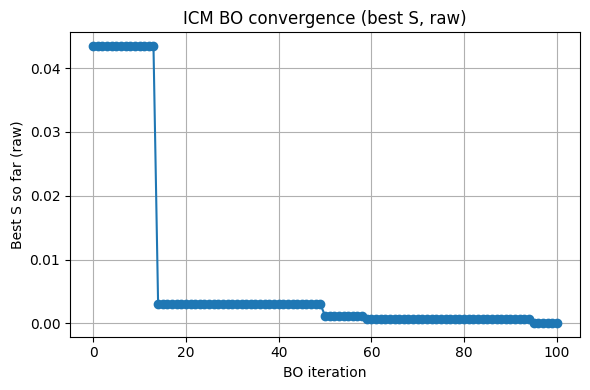

In [22]:
import matplotlib.pyplot as plt
import numpy as np

iters = np.arange(len(S_history_raw))

plt.figure(figsize=(6,4))
plt.plot(iters, S_history_raw, marker="o")
plt.xlabel("BO iteration")
plt.ylabel("Best S so far (raw)")
plt.title("ICM BO convergence (best S, raw)")
plt.grid(True)
plt.tight_layout()
plt.show()

Best OD index: 114
Best OD vector: [497.45688 513.40826 890.07983 902.251  ]
GT OD vector:  [500. 500. 900. 900.]


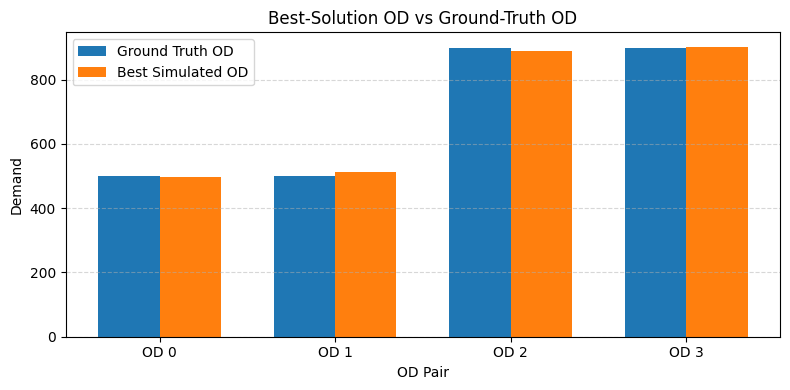

In [23]:
import numpy as np
import matplotlib.pyplot as plt


best_idx = int(np.argmin(S_obs_history_raw))
best_od = train_X_icm[best_idx].cpu().numpy() 

# Ground truth OD
gt_od = gt_od_df["count"].astype(float).values  

print("Best OD index:", best_idx)
print("Best OD vector:", best_od)
print("GT OD vector: ", gt_od)


labels = [f"OD {i}" for i in range(len(gt_od))]

x = np.arange(len(gt_od))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, gt_od,  width, label="Ground Truth OD")
plt.bar(x + width/2, best_od, width, label="Best Simulated OD")

plt.xlabel("OD Pair")
plt.ylabel("Demand")
plt.title("Best-Solution OD vs Ground-Truth OD")
plt.xticks(x, labels)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [24]:
# Check the actual noise structure
likelihood = icm_model.likelihood
print(f"Likelihood type: {type(likelihood)}")
print(f"Likelihood num_tasks: {likelihood.num_tasks}")

# Check different noise attributes
print(f"\nNoise attributes:")
print(f"  noise: {likelihood.noise.shape if hasattr(likelihood.noise, 'shape') else 'scalar'}")
print(f"  noise.data: {likelihood.noise.data.shape if hasattr(likelihood.noise.data, 'shape') else 'scalar'}")

# Try accessing task-specific noise if it exists
if hasattr(likelihood, 'task_noises'):
    print(f"  task_noises: {likelihood.task_noises.shape if hasattr(likelihood.task_noises, 'shape') else 'N/A'}")
    print(f"  task_noises.data: {likelihood.task_noises.data}")

# List all attributes
print(f"\nAll likelihood attributes containing 'noise':")
for attr in dir(likelihood):
    if 'noise' in attr.lower():
        try:
            val = getattr(likelihood, attr)
            if not callable(val):
                print(f"  {attr}: {val}")
        except:
            pass

Likelihood type: <class 'gpytorch.likelihoods.multitask_gaussian_likelihood.MultitaskGaussianLikelihood'>
Likelihood num_tasks: 14

Noise attributes:
  noise: torch.Size([1])
  noise.data: torch.Size([1])
  task_noises: torch.Size([14])
  task_noises.data: tensor([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001, 0.0001, 0.0001, 0.0001, 0.0001])

All likelihood attributes containing 'noise':
  has_global_noise: True
  has_task_noise: True
  noise: tensor([1.0000e-04], grad_fn=<AddBackward0>)
  raw_noise: Parameter containing:
tensor([-35.9883], requires_grad=True)
  raw_task_noises: Parameter containing:
tensor([-12.3869, -13.5224, -12.5437, -12.5134, -12.3128, -15.6713, -12.6509,
        -13.2232, -13.7417, -14.2024, -14.7044, -13.4568, -13.3108, -12.1788],
       requires_grad=True)
  task_noises: tensor([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001, 0.0001, 0.0001, 0.0001, 0.0001], grad_fn=<AddBackward0>

In [25]:
# Check task-specific noise (this is what you want!)
task_noises = icm_model.likelihood.task_noises.data
num_tasks = len(task_noises)

print(f"Number of tasks (edges): {num_tasks}")
print(f"\nNoise per task:")
print("-" * 50)
for task_idx in range(num_tasks):
    noise_val = task_noises[task_idx].item()
    status = ""
    if abs(noise_val - 1e-4) < 1e-5:
        status = " LOWER LIMIT"
    elif abs(noise_val - 1.0) < 1e-5:
        status = "  UPPER LIMIT"
    print(f"  Task {task_idx:3d}: {noise_val:.6f}{status}")

print("-" * 50)
print(f"Summary: min={task_noises.min():.6f}, max={task_noises.max():.6f}, mean={task_noises.mean():.6f}")

# Check limits
lower_bound = 1e-4
upper_bound = 1.0
at_lower = (task_noises - lower_bound).abs() < 1e-5
at_upper = (task_noises - upper_bound).abs() < 1e-5

if at_lower.any():
    task_indices = torch.where(at_lower)[0].tolist()
    print(f"\n  {at_lower.sum()} task(s) at LOWER limit: tasks {task_indices}")
if at_upper.any():
    task_indices = torch.where(at_upper)[0].tolist()
    print(f"  {at_upper.sum()} task(s) at UPPER limit: tasks {task_indices}")

Number of tasks (edges): 14

Noise per task:
--------------------------------------------------
  Task   0: 0.000104 LOWER LIMIT
  Task   1: 0.000101 LOWER LIMIT
  Task   2: 0.000104 LOWER LIMIT
  Task   3: 0.000104 LOWER LIMIT
  Task   4: 0.000104 LOWER LIMIT
  Task   5: 0.000100 LOWER LIMIT
  Task   6: 0.000103 LOWER LIMIT
  Task   7: 0.000102 LOWER LIMIT
  Task   8: 0.000101 LOWER LIMIT
  Task   9: 0.000101 LOWER LIMIT
  Task  10: 0.000100 LOWER LIMIT
  Task  11: 0.000101 LOWER LIMIT
  Task  12: 0.000102 LOWER LIMIT
  Task  13: 0.000105 LOWER LIMIT
--------------------------------------------------
Summary: min=0.000100, max=0.000105, mean=0.000102

  14 task(s) at LOWER limit: tasks [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [26]:
# B matrix (task covariance / coregionalization)
with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix.to_dense()
print("B shape:", B.shape)
print(B)

B shape: torch.Size([14, 14])
tensor([[ 41.0267,  41.0810,  41.0938,  20.3289,   6.7684,   6.6804,  20.4512,
          20.3951,   6.7382,  -1.7883,   4.4190, -10.1781,   7.9255,   0.4347],
        [ 41.0810,  41.1364,  41.1488,  20.4503,   6.6516,   6.5627,  20.5726,
          20.5165,   6.6212,  -1.7656,   4.4240, -10.2089,   7.9022,   0.4593],
        [ 41.0938,  41.1488,  41.1618,  20.4672,   6.6275,   6.5384,  20.5895,
          20.5334,   6.5971,  -1.7638,   4.4236, -10.2164,   7.8990,   0.4641],
        [ 20.3289,  20.4503,  20.4672,  48.0206,  -8.8768,  -9.1453,  48.0889,
          48.0478,  -8.9229,  10.5971,   6.9221,  -4.6892,  -3.6766,   3.6094],
        [  6.7684,   6.6516,   6.6275,  -8.8768,  34.4142,  34.5660,  -8.8056,
          -8.8388,  34.4393,  -2.8982,   3.1065,   3.8145,   8.3488,  -5.8097],
        [  6.6804,   6.5627,   6.5384,  -9.1453,  34.5660,  34.7283,  -9.0744,
          -9.1074,  34.5940,  -2.9588,   3.0817,   3.8526,   8.3920,  -5.8465],
        [ 20.451

In [27]:
with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix.to_dense()
    d = torch.sqrt(torch.diag(B))
    corr = B / (d[:, None] * d[None, :])
print(corr)

tensor([[ 1.0000,  1.0000,  1.0000,  0.4580,  0.1801,  0.1770,  0.4601,  0.4592,
          0.1792, -0.0829,  0.2338, -0.4831,  0.2542,  0.0199],
        [ 1.0000,  1.0000,  1.0000,  0.4601,  0.1768,  0.1736,  0.4622,  0.4613,
          0.1758, -0.0817,  0.2338, -0.4839,  0.2531,  0.0210],
        [ 1.0000,  1.0000,  1.0000,  0.4604,  0.1761,  0.1729,  0.4624,  0.4616,
          0.1751, -0.0816,  0.2337, -0.4841,  0.2530,  0.0213],
        [ 0.4580,  0.4601,  0.4604,  1.0000, -0.2184, -0.2239,  1.0000,  1.0000,
         -0.2193,  0.4539,  0.3386, -0.2057, -0.1090,  0.1531],
        [ 0.1801,  0.1768,  0.1761, -0.2184,  1.0000,  0.9999, -0.2163, -0.2173,
          0.9999, -0.1466,  0.1795,  0.1977,  0.2924, -0.2911],
        [ 0.1770,  0.1736,  0.1729, -0.2239,  0.9999,  1.0000, -0.2219, -0.2229,
          0.9999, -0.1490,  0.1773,  0.1988,  0.2926, -0.2916],
        [ 0.4601,  0.4622,  0.4624,  1.0000, -0.2163, -0.2219,  1.0000,  1.0000,
         -0.2173,  0.4532,  0.3391, -0.2063, -0.1

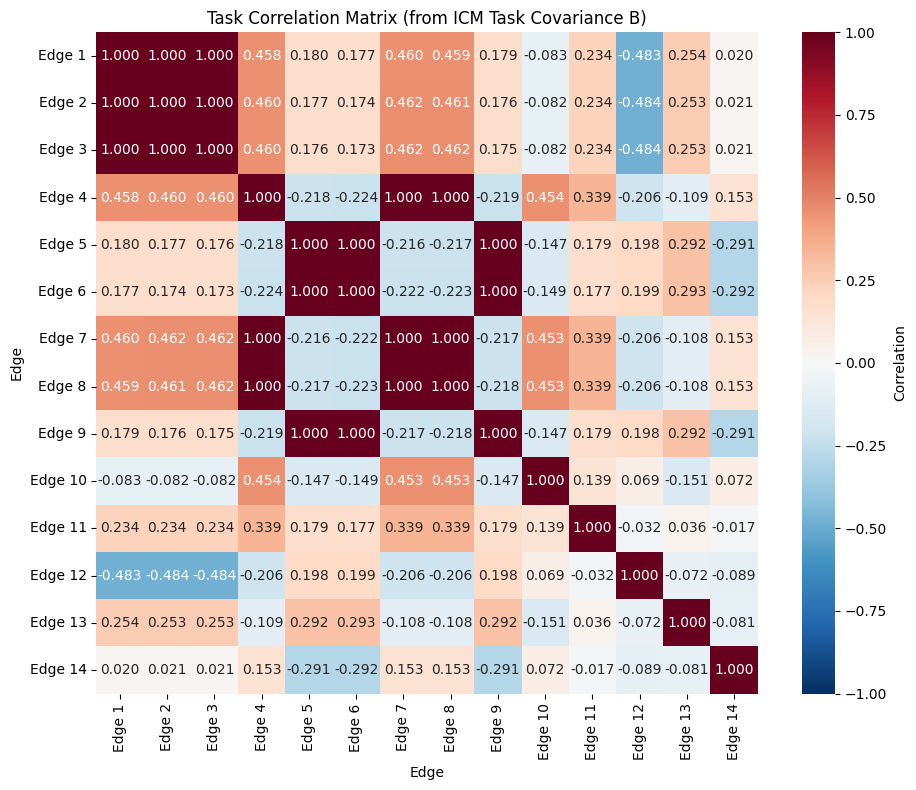

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix.to_dense()
    d = torch.sqrt(torch.diag(B)) # 
    corr = B / (d[:, None] * d[None, :])

# Convert to numpy for plotting
corr_np = corr.detach().cpu().numpy()



#Heat map 
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_np,
    annot=True,
    fmt='.3f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={'label': 'Correlation'},
    xticklabels=[f'Edge {i+1}' for i in range(L)],
    yticklabels=[f'Edge {i+1}' for i in range(L)],
)
plt.title('Task Correlation Matrix (from ICM Task Covariance B)')
plt.xlabel('Edge')
plt.ylabel('Edge')
plt.tight_layout()
plt.show()


In [29]:
edge_ids = gt_edge_data["edge_id"].tolist()

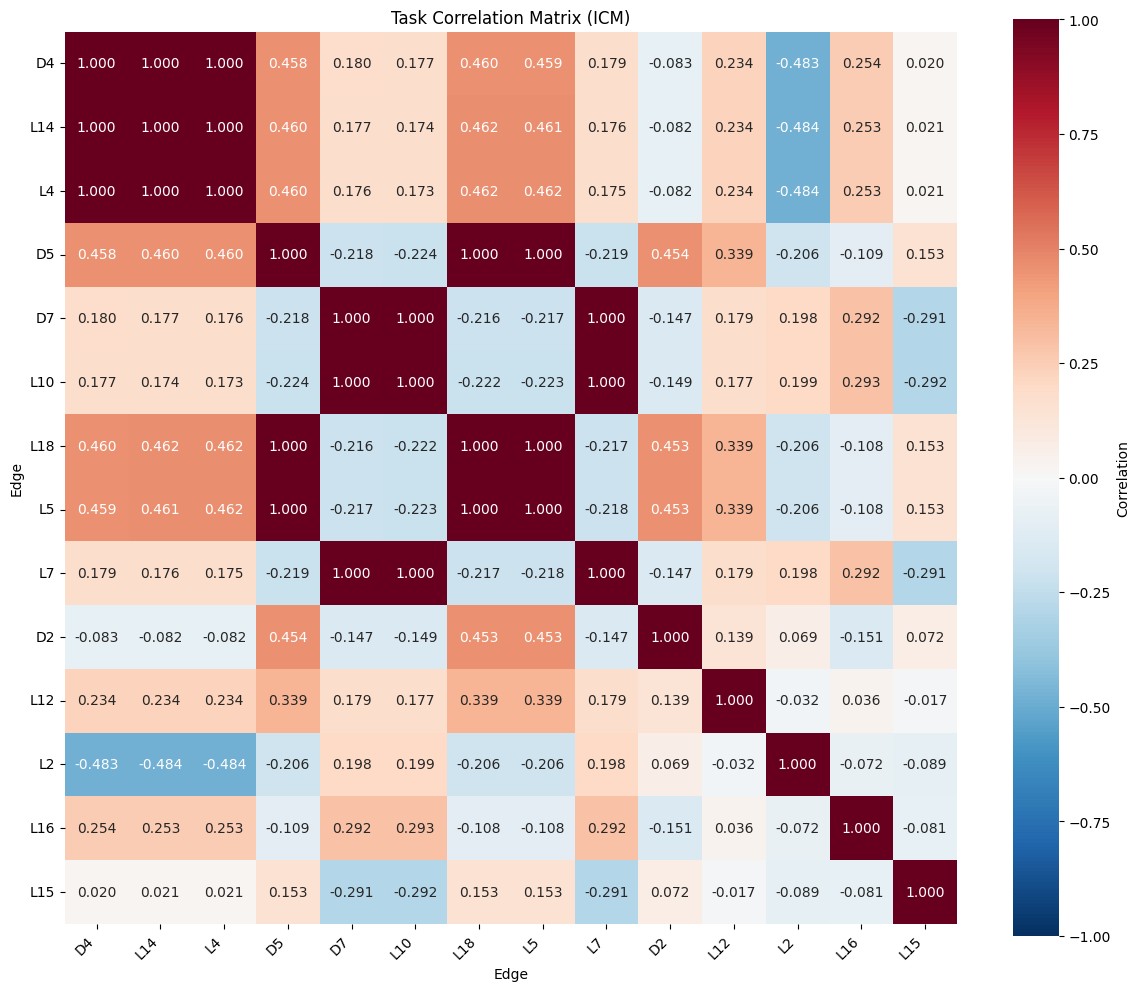

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# Compute correlation (your existing code)
with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix.to_dense()
    d = torch.sqrt(torch.diag(B))
    corr = B / (d[:, None] * d[None, :])

corr_np = corr.detach().cpu().numpy()

# Create heatmap with edge IDs as labels
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_np,
    annot=True,
    fmt='.3f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={'label': 'Correlation'},
    xticklabels=edge_ids,  # Use actual edge IDs
    yticklabels=edge_ids,
)
plt.title('Task Correlation Matrix (ICM)')
plt.xlabel('Edge')
plt.ylabel('Edge')
plt.xticks(rotation=45, ha='right')  # Rotate labels if needed
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## comparing scalar gp with icm 

In [31]:
print(train_X_icm_init)

tensor([[1995.0267,  208.7328, 1645.9578,  838.8643],
        [ 905.4018, 1676.1346,  146.5409, 1232.3398],
        [ 436.3676,  700.4452, 1395.8535,  347.9317],
        [1463.9845, 1168.5940,  896.6126, 1706.4115],
        [1172.4651,  780.6038,  309.8300, 1819.2373],
        [ 208.3256, 1373.7338, 1810.7881,  236.2808],
        [ 738.9139,  257.4842,  559.9794, 1367.4969],
        [1642.0144, 1849.8972, 1060.6097,  702.4102],
        [1538.6412,  590.4874,  634.4098,  101.0750],
        [ 564.7905, 1059.8531, 1135.5953, 1953.6954],
        [  97.3469,   66.7411,  384.3306,  587.1246],
        [1006.2524, 1536.8247, 1885.7072, 1482.5537],
        [1357.3130,  396.7292, 1282.7886, 1120.7015],
        [ 257.9750, 1991.8317,  784.0896,  949.7550],
        [ 790.8787,  889.4018, 1532.9441, 1567.5588],
        [1824.3027, 1483.7563,   33.9629,  486.5554],
        [1770.7188,  937.5904, 1217.8479, 1300.8279],
        [ 860.3464, 1408.1616,  715.2431,  628.0270],
        [ 329.1326,  461.825

In [32]:
#same
print(train_X_icm_init[1])
print(train_X_icm[1])


tensor([ 905.4018, 1676.1346,  146.5409, 1232.3398])
tensor([ 905.4018, 1676.1346,  146.5409, 1232.3398])


In [33]:
"""
GP Hyperparameter Optimization Process:

1. ExactMarginalLogLikelihood (MLL):
   - Computes the marginal log-likelihood: log p(Y | X, θ)
   - Evaluates how well the model explains the data given current hyperparameters θ
   - Provides gradients for optimization
   
   Example:
       mll = ExactMarginalLogLikelihood(model.likelihood, model)
       current_mll = mll()  # log p(Y | X, θ_current)

2. fit_gpytorch_mll:
   - Maximizes the MLL using gradient-based optimization (L-BFGS-B)
   - Updates all hyperparameters: θ ← θ + α * ∇_θ log p(Y | X, θ)
   - Finds optimal hyperparameters: θ* = argmax_θ log p(Y | X, θ)
   
   Example:
       fit_gpytorch_mll(mll)  # Optimizes hyperparameters
       # After fitting, model has optimized θ*

Hyperparameters optimized:
   - Kernel: lengthscales ℓ, output variance σ²_f
   - Task covariance: matrix B (rank-1: parameters b)
   - Noise: per-task observation noise σ² = [σ²₁, ..., σ²_L]
   - Mean: per-task mean μ = [μ₁, ..., μ_L]
"""

'\nGP Hyperparameter Optimization Process:\n\n1. ExactMarginalLogLikelihood (MLL):\n   - Computes the marginal log-likelihood: log p(Y | X, θ)\n   - Evaluates how well the model explains the data given current hyperparameters θ\n   - Provides gradients for optimization\n\n   Example:\n       mll = ExactMarginalLogLikelihood(model.likelihood, model)\n       current_mll = mll()  # log p(Y | X, θ_current)\n\n2. fit_gpytorch_mll:\n   - Maximizes the MLL using gradient-based optimization (L-BFGS-B)\n   - Updates all hyperparameters: θ ← θ + α * ∇_θ log p(Y | X, θ)\n   - Finds optimal hyperparameters: θ* = argmax_θ log p(Y | X, θ)\n\n   Example:\n       fit_gpytorch_mll(mll)  # Optimizes hyperparameters\n       # After fitting, model has optimized θ*\n\nHyperparameters optimized:\n   - Kernel: lengthscales ℓ, output variance σ²_f\n   - Task covariance: matrix B (rank-1: parameters b)\n   - Noise: per-task observation noise σ² = [σ²₁, ..., σ²_L]\n   - Mean: per-task mean μ = [μ₁, ..., μ_L]\n'

In [34]:
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from MOGP.helpers_MOGP import fit_gpytorch_mll_with_retries
import numpy as np
from src.models.gp_models import initialize_vanillabo_model
from src.utils.seed import set_seed

if "train_X_icm_init" not in locals():
    train_X_icm_init = train_X_icm.clone()
if "train_Y_icm_raw_init" not in locals():
    train_Y_icm_raw_init = train_Y_icm_raw.clone()

weights_uniform = torch.ones(L, device=device, dtype=dtype)
weights_uniform = weights_uniform / weights_uniform.sum()

vanilla_histories_raw = []

for r in range(N_RESTARTS):
    print(f"\n\n============================")
    print(f"  {r+1}/{N_RESTARTS}")
    print("============================\n")

    ##
    seed = 42 + r
    set_seed(seed)
    print(f"[SEED] Set seed to {seed} for restart {r+1}")
    ###


    train_X_van = train_X_icm_init.clone()

    # Aggregate initial per-edge errors into a single scalar S for scalar gp ( vanilla bo ) target 
    train_Y_raw_van = (train_Y_icm_raw_init * weights_uniform).sum(dim=1) 

    S_raw_all = train_Y_raw_van 
    best_S_raw = S_raw_all.min().item()

    S_history_raw_van = [best_S_raw]
    S_obs_history_raw_van = S_raw_all.detach().cpu().tolist()

    for it in range(N_BO_ITERS):
        print("\n\n============================")
        print(f"    VANILLA BO ITER {it+1}/{N_BO_ITERS}")
        print("============================\n")


        # Fit vanilla GP on aggregated S (outcome_transform handles standardization)
        train_X_norm_van = normalize(train_X_van, bounds=bounds)


        model = initialize_vanillabo_model(train_X_norm_van, S_raw_all.unsqueeze(-1), kernel="matern-2p5")
        # raw values as outcome trasnform handles standardization 
        



        #### fitting the gp : finding the best hyperparameters 
        mll = ExactMarginalLogLikelihood(model.likelihood, model) ## compute the marginal log likelihood 


        #fit_gpytorch_mll(mll)
        fit_gpytorch_mll_with_retries(  # maximize the marginal log likelihood with default optimizer L-BFGS-B
            mll,
            max_retries=3,
            base_jitter=1e-3,
            initial_jitter=0.0,
            jitter_multiplier=10.0,
            verbose=True,)

        model.eval() # making predictions



        ##### inference : compute the posterior mean and varaince at test points 
        EI = ExpectedImprovement(
            model=model, # EI call model.posterior internally, ExpectedImprovement is designed to work with a model that can compute posteriors at arbitrary points.
            best_f=best_S_raw,
            maximize=False,
        )

        x_next_norm, acq_val = optimize_acqf(
            EI,
            bounds=bounds_norm,
            q=1,
            num_restarts=config["NUM_RESTARTS"],
            raw_samples=config["RAW_SAMPLES"],
        )


        x_next_norm = x_next_norm.detach()

        x_next_real = (
            unnormalize(x_next_norm, bounds)
            .view(-1)
            .cpu()
            .numpy()
        )
        print(f"[ACQ] x_next_norm = {x_next_norm.cpu().numpy()}")
        print(f"[ACQ] Candidate OD (real space) = {x_next_real}")

        # Run SUMO simulation for new od 
        sim_dir = f"{config['simulation_run_path']}/vanilla_bo_restart_{r}/iter_{it}"
        Path(sim_dir).mkdir(parents=True, exist_ok=True)

        new_od_xml    = f"{sim_dir}/od.xml"
        prefix_output = f"{sim_dir}/sim"

        base_od = gt_od_df.copy()
        base_od["count"] = x_next_real
        base_od = base_od.rename(columns={"fromTaz": "from", "toTaz": "to"})

        create_taz_xml(
            new_od_xml,
            base_od,
            config["od_duration_sec"],
            base_path,
        )

        simulate_od(
            new_od_xml,
            prefix_output,
            base_path,
            config["net_xml"],
            config["taz2edge_xml"],
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"],
        )

        # Compute aggregated loss 
        sim_edge_out = f"{prefix_output}_{config['EDGE_OUT_STR']}"
        curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(
            base_dir=base_path,
            sim_edge_file=sim_edge_out,
            prefix_output=prefix_output,
            SUMO_PATH=config["SUMO_PATH"],
        )

        curr_loss = compute_nrmse_counts_all_edges(
            gt_edge_data,
            curr_loop_stats,
        )
        S_next_raw = torch.tensor(curr_loss, device=device, dtype=dtype)

    
        S_obs_history_raw_van.append(S_next_raw.item())
        if S_next_raw.item() < best_S_raw:
            best_S_raw = S_next_raw.item()

        S_history_raw_van.append(best_S_raw)

        # Update training data
        train_X_van = torch.cat(
            [train_X_van, torch.tensor(x_next_real, device=device, dtype=dtype).view(1, -1)],
            dim=0,
        )
        train_Y_raw_van = torch.cat(
            [train_Y_raw_van, S_next_raw.view(1)],
            dim=0,
        )
        S_raw_all = train_Y_raw_van

    vanilla_histories_raw.append(S_history_raw_van)

# Mean curve across restarts (raw)




min_len = min(len(h) for h in vanilla_histories_raw)
S_history_raw_van = np.mean([h[:min_len] for h in vanilla_histories_raw], axis=0).tolist()

print("\nFinished Vanilla BO.")
print(f"Final best S (raw, mean) = {S_history_raw_van[-1]:.6f}")




  1/1

[SEED] Set seed to 42 for restart 1


    VANILLA BO ITER 1/100

ICM fit successful on attempt 1 (jitter=0.0e+00).


/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.26927277 0.42764223 0.         0.        ]]
[ACQ] Candidate OD (real space) = [538.54553 855.2844    0.        0.     ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_0/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_0/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_0/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_1/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_1/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restar

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.80
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_2/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_2/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (4ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (4ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restar

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.22023495 0.3198138  0.49850756 0.42011252]]
[ACQ] Candidate OD (real space) = [440.46988 639.62756 997.01514 840.22504]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_3/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_3/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_3/sim_trips_beforeRteUpdates.xml
Success.time 299.66
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_3/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_3/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.         0.46414608 0.70653784 0.26578853]]
[ACQ] Candidate OD (real space) = [   0.      928.2922 1413.0757  531.577 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_4/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_4/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_4/sim_trips_beforeRteUpdates.xml
Success.time 299.47
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_4/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_4/sim_trips.xml -b 0 -e 57600 --ad

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.22924283 0.27571246 0.55438673 0.43044353]]
[ACQ] Candidate OD (real space) = [ 458.48566  551.4249  1108.7734   860.887  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_5/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_5/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_5/sim_trips.xml -b 0 -e 57600 

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 298.85
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_6/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restar

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.46303967 0.         0.         0.5983006 ]]
[ACQ] Candidate OD (real space) = [ 926.07935    0.         0.      1196.6012 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_7/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_7/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_7/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_7/sim_trips.xml -b 0 -e 57600 

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=c

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenha

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenha

ICM fit failed on attempt 3 (jitter=1.0e-02): All attempts to fit the model have failed.
ICM fit failed after all retry attempts.
[ACQ] x_next_norm = [[0.10437179 0.229979   0.41124716 0.61081994]]
[ACQ] Candidate OD (real space) = [ 208.74359  459.95798  822.4943  1221.6399 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_8/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_8/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_8/sim_trips_beforeRteUpdates.xml
Success.time 299.67
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.92
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_9/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restar

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_10/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.19452225 0.14590532 0.3666115  0.49279392]]
[ACQ] Candidate OD (real space) = [389.0445  291.81064 733.223   985.5878 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_11/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_11/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_11/sim_trips_beforeRteUpdates.xml
Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.32053277 0.00725135 0.5710283  0.5818608 ]]
[ACQ] Candidate OD (real space) = [ 641.06555    14.502701 1142.0566   1163.7216  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_12/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_12/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_12/sim_trips_beforeRteUpdates.xml
Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.04017343 0.50291485 0.01820986 0.8521931 ]]
[ACQ] Candidate OD (real space) = [  80.34687 1005.8297    36.41972 1704.3862 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_13/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_13/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_13/sim_trips_beforeRteUpdates.xml
Success.time 299.91
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.17
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_14/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (4ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.16456702 0.47586638 0.45707586 0.03488588]]
[ACQ] Candidate OD (real space) = [329.13403 951.7327  914.15173  69.77177]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_15/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_15/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_15/sim_trips_beforeRteUpdates.xml
Success.time 299.21
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_15/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.77
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_16/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_16/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (4ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_17/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_17/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.27
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_18/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_18/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (7ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (4ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.6129824  0.00104814 0.383255   0.8751764 ]]
[ACQ] Candidate OD (real space) = [1225.9648       2.0962768  766.51      1750.3529   ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_19/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_19/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_19/sim_trips_beforeRteUpdates.xml
Success.time 299.23
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_19/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_19/sim_trips.xml -

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.41441724 0.18960541 0.00841774 0.6803738 ]]
[ACQ] Candidate OD (real space) = [ 828.8345    379.21082    16.835476 1360.7476  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_20/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_20/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_20/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_20/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_20/sim_trips.xml -b 0 

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_21/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_21/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (10ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (3ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_21/sim_t

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


ICM fit successful on attempt 1 (jitter=0.0e+00).
[ACQ] x_next_norm = [[0.06224587 0.01286481 0.92296356 0.49896854]]
[ACQ] Candidate OD (real space) = [ 124.49174    25.729624 1845.9271    997.9371  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_22/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_22/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_22/sim_trips_beforeRteUpdates.xml
Success.time 299.43
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_22/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.54
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_23/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_23/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.10233612 0.54105467 0.5785507  0.19033186]]
[ACQ] Candidate OD (real space) = [ 204.67223 1082.1094  1157.1014   380.66373]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_24/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_24/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_24/sim_trips_beforeRteUpdates.xml
Success.time 299.58
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_24/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_24/sim_trips.xml -b 0 -e 5

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_25/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_25/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_25/sim_tr

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.17
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_26/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_26/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (6ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.33292663 0.00317449 0.4400396  0.18633628]]
[ACQ] Candidate OD (real space) = [665.8533      6.3489842 880.0792    372.67255  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_27/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_27/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_27/sim_trips_beforeRteUpdates.xml
Success.time 299.83


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_27/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_27/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (4ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_27/sim_tr

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.68
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_28/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_28/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (6ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (3ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.14294976 0.44897267 0.5146481  0.36210704]]
[ACQ] Candidate OD (real space) = [ 285.8995   897.9454  1029.2961   724.21405]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_29/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_29/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_29/sim_trips_beforeRteUpdates.xml
Success.time 299.16
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_29/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2989982 0.2277477 0.4790993 0.3813766]]
[ACQ] Candidate OD (real space) = [597.9964 455.4954 958.1986 762.7532]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_30/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_30/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_30/sim_trips_beforeRteUpdates.xml


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.25
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_30/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_30/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (7ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.29
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_31/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_31/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (4ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.27
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_32/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_32/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (4ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.17767824 0.25236002 0.53574646 0.37252298]]
[ACQ] Candidate OD (real space) = [ 355.35648  504.72003 1071.4929   745.04596]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_33/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_33/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_33/sim_trips_beforeRteUpdates.xml


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Success.time 299.30
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_33/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_33/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.50
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_34/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_34/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 298.99
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_35/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_35/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.40317786 0.21582136 0.16397718 0.34732753]]
[ACQ] Candidate OD (real space) = [806.3557  431.6427  327.95435 694.6551 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_36/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_36/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_36/sim_trips_beforeRteUpdates.xml
Success.time 299.35
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_36/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.59
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_37/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_37/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (5ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.2950298  0.3782879  0.36236337 0.37777698]]
[ACQ] Candidate OD (real space) = [590.0596  756.5758  724.72675 755.55396]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_38/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_38/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_38/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_38/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.72
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_39/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_39/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (12ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (5ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_res

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.00998713 0.67149335 0.8899078  0.7711617 ]]
[ACQ] Candidate OD (real space) = [  19.974264 1342.9867   1779.8156   1542.3234  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_40/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_40/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_40/sim_trips_beforeRteUpdates.xml
Success.time 299.41
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_40/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.91
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_41/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_41/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.09113321 0.42814466 0.6750535  0.4222038 ]]
[ACQ] Candidate OD (real space) = [ 182.26642  856.2893  1350.1069   844.4076 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_42/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_42/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_42/sim_trips_beforeRteUpdates.xml
Success.time 299.82
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_42/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.2249582  0.21563293 0.38805395 0.5194146 ]]
[ACQ] Candidate OD (real space) = [ 449.91638  431.26587  776.1079  1038.8292 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_43/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_43/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_43/sim_trips_beforeRteUpdates.xml
Success.time 298.96
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_43/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_43/sim_trips.xml -b 0 -e 5

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.90188134 0.37453145 0.3672293  0.57654756]]
[ACQ] Candidate OD (real space) = [1803.7627   749.06287  734.4586  1153.0951 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_44/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_44/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_44/sim_trips_beforeRteUpdates.xml
Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_44/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.48
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_45/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_45/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.17962332 0.32020167 0.441066   0.43056554]]
[ACQ] Candidate OD (real space) = [359.24664 640.4033  882.132   861.13104]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_46/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_46/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_46/sim_trips_beforeRteUpdates.xml
Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_46/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.23534961 0.5363521  0.38779905 0.516118  ]]
[ACQ] Candidate OD (real space) = [ 470.69922 1072.7042   775.5981  1032.236  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_47/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_47/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_47/sim_trips_beforeRteUpdates.xml
Success.time 299.68
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_47/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.18571018 0.27174947 0.48366717 0.5054955 ]]
[ACQ] Candidate OD (real space) = [ 371.42035  543.49896  967.33435 1010.99097]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_48/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_48/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_48/sim_trips_beforeRteUpdates.xml
Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_48/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.45077986 0.01941467 0.01781992 0.94192606]]
[ACQ] Candidate OD (real space) = [ 901.5597     38.829334   35.63984  1883.8522  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_49/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_49/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_49/sim_trips_beforeRteUpdates.xml
Success.time 298.96
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_49/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.907129   0.6544561  0.6539813  0.42554253]]
[ACQ] Candidate OD (real space) = [1814.2579 1308.9121 1307.9626  851.0851]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_50/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_50/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_50/sim_trips_beforeRteUpdates.xml
Success.time 299.42
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_50/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.59
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_51/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_51/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.03
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_52/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_52/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (4ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.7051038  0.29000407 0.20770486 0.57864326]]
[ACQ] Candidate OD (real space) = [1410.2076   580.0082   415.40973 1157.2865 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_53/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_53/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_53/sim_trips_beforeRteUpdates.xml
Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_53/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_53/sim_trips.xml -b 0 -e 5

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.28474924 0.704933   0.75013536 0.25466654]]
[ACQ] Candidate OD (real space) = [ 569.4985  1409.866   1500.2708   509.33307]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_54/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_54/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_54/sim_trips_beforeRteUpdates.xml
Success.time 299.10
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_54/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_54/sim_trips.xml -b 0 -e 5

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.25677487 0.1680119  0.51329863 0.48245656]]
[ACQ] Candidate OD (real space) = [ 513.54974  336.0238  1026.5973   964.91315]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_55/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_55/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_55/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_55/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_55/sim_trips.xml -b 0 -e 5

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.7379134  0.5552177  0.20930052 0.34556636]]
[ACQ] Candidate OD (real space) = [1475.8269  1110.4354   418.60104  691.13275]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_56/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_56/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_56/sim_trips_beforeRteUpdates.xml
Success.time 299.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_56/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_56/sim_trips.xml -b 0 -e 5

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.250318   0.20632148 0.47330734 0.38361612]]
[ACQ] Candidate OD (real space) = [500.636   412.64294 946.6147  767.23224]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_57/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_57/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_57/sim_trips_beforeRteUpdates.xml
Success.time 298.89
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_57/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.35438257 0.6549612  0.09545647 0.595575  ]]
[ACQ] Candidate OD (real space) = [ 708.76514 1309.9225   190.91295 1191.1499 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_58/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_58/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_58/sim_trips_beforeRteUpdates.xml


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inp

Success.time 299.37
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_58/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_58/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (4ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_59/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_59/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (2ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.01601761 0.52734464 0.18541232 0.16023555]]
[ACQ] Candidate OD (real space) = [  32.035217 1054.6893    370.82465   320.4711  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_60/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_60/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_60/sim_trips_beforeRteUpdates.xml
Success.time 299.86
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_60/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.83
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_61/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_61/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (4ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.26376542 0.3911935  0.56405264 0.33976617]]
[ACQ] Candidate OD (real space) = [ 527.5308   782.387   1128.1052   679.53235]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_62/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_62/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_62/sim_trips_beforeRteUpdates.xml
Success.time 299.81
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_62/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.33609706 0.21711257 0.42617282 0.4139412 ]]
[ACQ] Candidate OD (real space) = [672.19415 434.22513 852.34564 827.8824 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_63/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_63/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_63/sim_trips_beforeRteUpdates.xml
Success.time 299.78
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_63/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.37514913 0.64483184 0.294887   0.7944211 ]]
[ACQ] Candidate OD (real space) = [ 750.2983 1289.6637  589.774  1588.8422]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_64/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_64/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_64/sim_trips_beforeRteUpdates.xml
Success.time 299.24
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_64/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inp

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.94819504 0.16611302 0.2490771  0.9139722 ]]
[ACQ] Candidate OD (real space) = [1896.3901   332.22604  498.1542  1827.9445 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_65/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_65/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_65/sim_trips_beforeRteUpdates.xml
Success.time 299.55
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_65/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.35900423 0.0956488  0.25083625 0.5200025 ]]
[ACQ] Candidate OD (real space) = [ 718.0085   191.2976   501.67252 1040.005  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_66/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_66/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_66/sim_trips_beforeRteUpdates.xml
Success.time 299.70
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_66/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linea

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.
ICM fit successful on attempt 3 (jitter=1.0e-02).
[ACQ] x_next_norm = [[0.2692736  0.05281329 0.33501935 0.6039578 ]]
[ACQ] Candidate OD (real space) = [ 538.54724  105.62659  670.0387  1207.9155 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_67/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_67/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_67/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_67/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inp

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.77107227 0.99408406 0.25785813 0.32359666]]
[ACQ] Candidate OD (real space) = [1542.1445  1988.1681   515.71625  647.1933 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_68/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_68/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_68/sim_trips_beforeRteUpdates.xml
Success.time 298.93
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_68/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.87
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_69/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_69/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (13ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (8ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_res

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.16245347 0.37531087 0.43694985 0.2458001 ]]
[ACQ] Candidate OD (real space) = [324.90695 750.62177 873.8997  491.6002 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_70/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_70/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_70/sim_trips_beforeRteUpdates.xml
Success.time 299.14
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_70/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_70/sim_trips.xml -b 0 -e 57600

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.5381972  0.37518212 0.74569774 0.5355592 ]]
[ACQ] Candidate OD (real space) = [1076.3944   750.36426 1491.3955  1071.1184 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_71/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_71/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_71/sim_trips_beforeRteUpdates.xml
Success.time 299.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_71/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


[ACQ] x_next_norm = [[0.28567076 0.2377349  0.3854788  0.39719248]]
[ACQ] Candidate OD (real space) = [571.3415  475.4698  770.9576  794.38495]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_72/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_72/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_72/sim_trips_beforeRteUpdates.xml
Success.time 299.68
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_72/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_72/sim_trips.xml -b 0 -e 57600

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.71
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_73/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_73/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (8ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (3ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.22
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_74/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_74/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (4ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.25618127 0.22165959 0.32002506 0.44041872]]
[ACQ] Candidate OD (real space) = [512.36255 443.31918 640.0501  880.83746]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_75/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_75/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_75/sim_trips_beforeRteUpdates.xml
Success.time 299.49
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_75/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.60809255 0.28180876 0.5177883  0.2186479 ]]
[ACQ] Candidate OD (real space) = [1216.185    563.61755 1035.5765   437.2958 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_76/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_76/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_76/sim_trips_beforeRteUpdates.xml
Success.time 299.66
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_76/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_76/sim_trips.xml -b 0 -e 5

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.21195461 0.22060652 0.46419552 0.55849576]]
[ACQ] Candidate OD (real space) = [ 423.9092   441.21304  928.39105 1116.9916 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_77/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_77/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_77/sim_trips_beforeRteUpdates.xml
Success.time 299.84
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_77/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.16856974 0.32989797 0.51160616 0.42747316]]
[ACQ] Candidate OD (real space) = [ 337.1395   659.79596 1023.21234  854.9463 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_78/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_78/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_78/sim_trips_beforeRteUpdates.xml
Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_78/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.18173817 0.28517985 0.845913   0.9626927 ]]
[ACQ] Candidate OD (real space) = [ 363.47635  570.3597  1691.8259  1925.3854 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_79/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_79/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_79/sim_trips_beforeRteUpdates.xml
Success.time 299.14
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_79/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.3368414  0.19208866 0.42804897 0.5007795 ]]
[ACQ] Candidate OD (real space) = [ 673.6828   384.17734  856.09796 1001.559  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_80/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_80/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_80/sim_trips_beforeRteUpdates.xml
Success.time 299.78
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_80/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.00835887 0.02955176 0.31237707 0.7094255 ]]
[ACQ] Candidate OD (real space) = [  16.717731   59.103523  624.75415  1418.8511  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_81/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_81/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_81/sim_trips_beforeRteUpdates.xml
Success.time 299.26
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_81/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

[ACQ] x_next_norm = [[0.09448539 0.34869644 0.33753258 0.4680253 ]]
[ACQ] Candidate OD (real space) = [188.97078 697.3929  675.0652  936.0506 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_82/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_82/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_82/sim_trips_beforeRteUpdates.xml
Success.time 298.92
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_82/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_82/sim_trips.xml -b 0 -e 57600

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.51558715 0.56973505 0.23881964 0.7001257 ]]
[ACQ] Candidate OD (real space) = [1031.1743  1139.4701   477.63928 1400.2513 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_83/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_83/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_83/sim_trips_beforeRteUpdates.xml


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inp

Success.time 299.85
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_83/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_83/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (4ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.5171855  0.03544465 0.7305676  0.16798943]]
[ACQ] Candidate OD (real space) = [1034.371     70.8893  1461.1351   335.97885]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_84/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_84/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_84/sim_trips_beforeRteUpdates.xml
Success.time 299.90
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_84/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.21
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_85/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_85/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.27073127 0.20153439 0.39408618 0.57987845]]
[ACQ] Candidate OD (real space) = [ 541.4625   403.0688   788.17236 1159.757  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_86/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_86/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_86/sim_trips_beforeRteUpdates.xml
Success.time 299.09


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_86/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_86/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_86/sim_tr

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-02 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.33635253 0.25678185 0.33107626 0.60004807]]
[ACQ] Candidate OD (real space) = [ 672.7051  513.5637  662.1525 1200.0962]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_87/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_87/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_87/sim_trips_beforeRteUpdates.xml
Success.time 299.13
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_87/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_88/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_88/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (4ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.12
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_89/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_89/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (2ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/fit.py:214: OptimizationWarning: `scipy_minimize` terminated with status OptimizationStatus.FAILURE, displaying original message from `scipy.optimize.minimize`: ABNORMAL: 
  result = optimizer(mll, closure=closure, **optimizer_kwargs)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linea

ICM fit failed on attempt 2 (jitter=1.0e-03): All attempts to fit the model have failed.
ICM fit successful on attempt 3 (jitter=1.0e-02).
[ACQ] x_next_norm = [[0.00586286 0.8350357  0.95023835 0.0816812 ]]
[ACQ] Candidate OD (real space) = [  11.725713 1670.0714   1900.4767    163.3624  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_90/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_90/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_90/sim_trips_beforeRteUpdates.xml
Success.time 299.55
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_90/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.17935027 0.37101147 0.5454151  0.36635378]]
[ACQ] Candidate OD (real space) = [ 358.70053  742.02295 1090.8302   732.7076 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_91/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_91/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_91/sim_trips_beforeRteUpdates.xml
Success.time 298.98
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_91/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.03593468 0.9565298  0.04731014 0.92759484]]
[ACQ] Candidate OD (real space) = [  71.86937  1913.0596     94.620285 1855.1897  ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_92/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_92/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_92/sim_trips_beforeRteUpdates.xml
Success.time 299.43
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_92/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanill

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.02642471 0.74203265 0.4632082  0.06222977]]
[ACQ] Candidate OD (real space) = [  52.849426 1484.0653    926.4164    124.45953 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_93/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_93/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_93/sim_trips_beforeRteUpdates.xml
Success.time 299.29
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_93/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xm

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_94/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_94/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_95/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_95/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_95/sim_trips_beforeRteUpdates.xml
Success.time 299.74
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_95/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_95/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validat

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.9722222  0.31039953 0.5830242  0.11370039]]
[ACQ] Candidate OD (real space) = [1944.4445   620.7991  1166.0485   227.40079]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_96/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_96/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_96/sim_trips_beforeRteUpdates.xml
Success.time 299.61
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_96/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/va

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.31996453 0.23313428 0.53425306 0.6190383 ]]
[ACQ] Candidate OD (real space) = [ 639.9291   466.26855 1068.5061  1238.0765 ]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_97/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_97/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_97/sim_trips_beforeRteUpdates.xml
Success.time 299.86
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_97/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2

ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.
ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.6998856  0.7829651  0.51594794 0.27802604]]
[ACQ] Candidate OD (real space) = [1399.7712  1565.9303  1031.8959   556.05206]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_98/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_98/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_98/sim_trips_beforeRteUpdates.xml


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


Success.time 298.98
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_98/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_98/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml' ... done (3ms).
Loading additional-files from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/additional.xml' ... done (1ms).
Loading route-files incrementally from '/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_rest

/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/src/models/gp_models.py:50: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


ICM fit failed on attempt 1 (jitter=0.0e+00): All attempts to fit the model have failed.


/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)
/Users/inesbenhamza/Downloads/Sumo_od_calibration 2/env/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inp

ICM fit successful on attempt 2 (jitter=1.0e-03).
[ACQ] x_next_norm = [[0.6153376  0.6029495  0.86328423 0.18557456]]
[ACQ] Candidate OD (real space) = [1230.6752 1205.899  1726.5685  371.1491]
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_99/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_99/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_99/sim_trips_beforeRteUpdates.xml
Success.time 299.15
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/vanilla_bo_restart_0/iter_99/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/vanill

# convergence curve

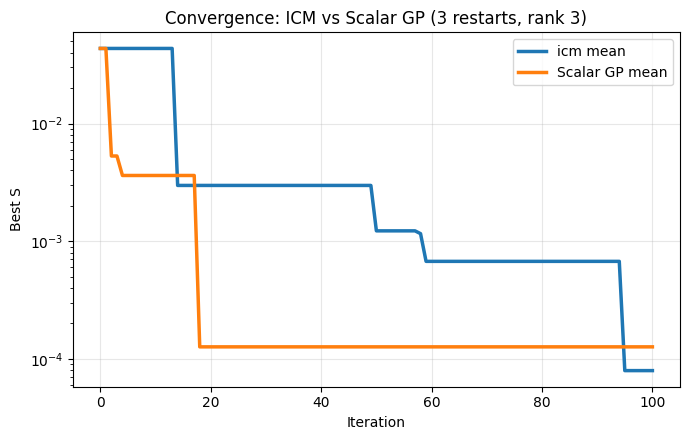

In [35]:

import matplotlib.pyplot as plt
import numpy as np


min_len = min(
    min(len(h) for h in icm_histories_raw),
    min(len(h) for h in vanilla_histories_raw),
)

xs = np.arange(min_len)

plt.figure(figsize=(7,4.5))


for h in icm_histories_raw:
    plt.plot(xs, np.array(h[:min_len]), color="tab:blue", alpha=0.2)

for h in vanilla_histories_raw:
    plt.plot(xs, np.array(h[:min_len]), color="tab:orange", alpha=0.2)

# Plot means (bold)
icm_mean = np.mean([h[:min_len] for h in icm_histories_raw], axis=0)
van_mean = np.mean([h[:min_len] for h in vanilla_histories_raw], axis=0)

plt.plot(xs, icm_mean, label="icm mean", color="tab:blue", linewidth=2.5)
plt.plot(xs, van_mean, label="Scalar GP mean", color="tab:orange", linewidth=2.5)



plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Best S")
plt.title("Convergence: ICM vs Scalar GP (3 restarts, rank 3)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
print("len(train_X_icm_init):", len(train_X_icm_init))
print("len(train_X_icm):", len(train_X_icm))
print("best raw init:", min(S_obs_history_raw_van))

len(train_X_icm_init): 20
len(train_X_icm): 120
best raw init: 0.00012660810898523778


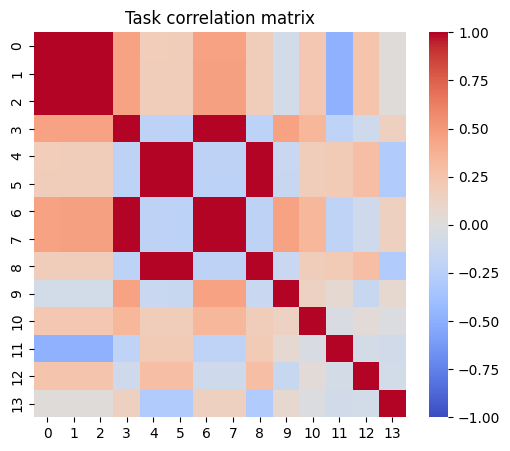

In [37]:
with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix.to_dense()
    d = torch.sqrt(torch.diag(B))
    corr = B / (d[:, None] * d[None, :])

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(corr.cpu().numpy(), cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Task correlation matrix")
plt.show()

In [38]:
with torch.no_grad():
    task = icm_model.covar_module.task_covar_module
    B = task.covar_matrix.to_dense()
    evals = torch.linalg.eigvalsh(B).flip(0)  # descending
    print(evals[:10])
    print("ratio e3/e2:", (evals[2] / evals[1]).item())


tensor([2.0058e+02, 1.2930e+02, 5.6684e+01, 1.9134e+01, 1.0382e+01, 7.4918e+00,
        7.0515e+00, 6.6933e+00, 4.8663e-03, 2.4904e-03])
ratio e3/e2: 0.4383769631385803


14.8057 / 25.8585 = 52 therefore rank‑3 could still capture meaningful structure

In [39]:
with torch.no_grad():
    task = icm_model.covar_module.task_covar_module
    W = task.covar_factor

    # Correct kappa
    kappa = task.var  # <-- correct

    B_lr = W @ W.t()
    B_d  = torch.diag(kappa)
    B    = B_lr + B_d

    frac_diag = torch.trace(B_d) / torch.trace(B)
    marg = torch.diag(B)
    frac_diag_per_task = kappa / marg

    print("Fraction diagonal:", frac_diag.item())
    print("diag fraction per task (min/mean/max/median):",
          frac_diag_per_task.min().item(),
          frac_diag_per_task.mean().item(),
          frac_diag_per_task.max().item(), 
          frac_diag_per_task.median().item()
          )
    print("first 10:", frac_diag_per_task[:])



Fraction diagonal: 0.1200673058629036
diag fraction per task (min/mean/max/median): 1.3281814403853787e-07 0.27968138456344604 0.905915379524231 7.084782555466518e-05
first 10: tensor([6.7628e-07, 1.1774e-05, 1.3282e-07, 3.9521e-07, 7.3861e-05, 1.7468e-04,
        4.5914e-07, 6.0988e-07, 7.0848e-05, 6.8337e-01, 8.1790e-01, 6.6728e-01,
        8.4075e-01, 9.0592e-01])


In [40]:
frac = frac_diag_per_task.detach().cpu()
idx = torch.argsort(frac)  # lowest = most shared
for i in idx:
    print(i.item(), float(frac[i]))


2 1.3281814403853787e-07
3 3.952115150696045e-07
6 4.5913813551123894e-07
7 6.098848643887322e-07
0 6.762810471627745e-07
1 1.1773856385843828e-05
8 7.084782555466518e-05
4 7.386112702079117e-05
5 0.00017467551515437663
11 0.6672770977020264
9 0.6833727955818176
10 0.8178955316543579
12 0.8407450318336487
13 0.905915379524231


In [41]:
with torch.no_grad():
    task = icm_model.covar_module.task_covar_module
    W = task.covar_factor  # [L, r]
    print("W (per-task loadings):")
    print(W)


W (per-task loadings):
Parameter containing:
tensor([[-4.7367,  4.0913,  1.3606],
        [-4.7275,  4.1141,  1.3639],
        [-4.7260,  4.1184,  1.3660],
        [-0.2195,  5.9138, -3.6055],
        [-4.5975, -2.9637, -2.1192],
        [-4.6103, -3.0034, -2.1089],
        [-0.2389,  5.9224, -3.6091],
        [-0.2301,  5.9177, -3.6059],
        [-4.5982, -2.9717, -2.1195],
        [ 0.7332,  0.9085, -1.4936],
        [-0.6611,  0.6081, -0.8822],
        [ 0.5969, -1.4346, -1.0887],
        [-1.8309, -0.3616,  0.5381],
        [ 0.6507,  0.7801,  0.2389]], requires_grad=True)


In [42]:
with torch.no_grad():
    task = icm_model.covar_module.task_covar_module
    W = task.covar_factor  # [L, r]

    # Safe way to get diagonal variance
    if hasattr(task, "raw_var") and hasattr(task, "raw_var_constraint"):
        kappa = task.raw_var_constraint.transform(task.raw_var)
    else:
        kappa = task.var  # fallback

    B_lr = W @ W.t()
    B_d  = torch.diag(kappa)
    B    = B_lr + B_d

    print("trace low-rank / trace total =", (torch.trace(B_lr) / torch.trace(B)).item())
    print("||B_lr||_F / ||B_total||_F =", (torch.linalg.norm(B_lr) / torch.linalg.norm(B)).item())
    print("frac diag =", (torch.trace(B_d) / torch.trace(B)).item())


trace low-rank / trace total = 0.879932701587677
||B_lr||_F / ||B_total||_F = 0.9919580817222595
frac diag = 0.1200673058629036


In [43]:
with torch.no_grad():
    task = icm_model.covar_module.task_covar_module
    B = task.covar_matrix.to_dense()  # <-- important

    evals, evecs = torch.linalg.eigh(B)  # ascending
    evals = torch.flip(evals, dims=[0])
    evecs = torch.flip(evecs, dims=[1])  # columns aligned with evals

print("Top eigenvalues:", evals[:5])
print("Top eigenvectors (first 3 modes):")
print(evecs[:, :3])


Top eigenvalues: tensor([200.5813, 129.3033,  56.6836,  19.1336,  10.3816])
Top eigenvectors (first 3 modes):
tensor([[-0.3547,  0.2706,  0.3261],
        [-0.3559,  0.2692,  0.3270],
        [-0.3561,  0.2689,  0.3274],
        [-0.4438, -0.1568, -0.3015],
        [ 0.0533,  0.4665, -0.3133],
        [ 0.0558,  0.4687, -0.3130],
        [-0.4448, -0.1555, -0.3016],
        [-0.4443, -0.1560, -0.3014],
        [ 0.0538,  0.4668, -0.3136],
        [-0.0673, -0.0931, -0.2012],
        [-0.0708,  0.0386, -0.1044],
        [ 0.0937, -0.0076, -0.2107],
        [-0.0120,  0.1913,  0.1157],
        [-0.0336, -0.0834,  0.0567]])


In [44]:
with torch.no_grad():
    B = icm_model.covar_module.task_covar_module.covar_matrix
    evals = torch.linalg.eigvalsh(B).flip(0)   # descending
    print(evals[:10])
    print("λ4/λ3 =", (evals[3]/evals[2]).item())


tensor([2.0058e+02, 1.2930e+02, 5.6684e+01, 1.9134e+01, 1.0382e+01, 7.4918e+00,
        7.0515e+00, 6.6933e+00, 4.8690e-03, 2.4905e-03])
λ4/λ3 = 0.33755016326904297


In [45]:
with torch.no_grad():
    task = icm_model.covar_module.task_covar_module
    B = task.covar_matrix.to_dense()  

    evals, evecs = torch.linalg.eigh(B)
    evals = torch.flip(evals, dims=[0])
    evecs = torch.flip(evecs, dims=[1])

    v4 = evecs[:, 3]
    print("v4:", v4)
    print("top |weights| indices:", torch.topk(v4.abs(), k=5).indices)



v4: tensor([-0.0937, -0.0935, -0.0935,  0.0585, -0.0541, -0.0545,  0.0582,  0.0583,
        -0.0541,  0.0599,  0.0037,  0.0374,  0.9743,  0.0203])
top |weights| indices: tensor([12,  0,  1,  2,  9])


# Implementing KG , UCB

Thompson Sampling (TS)


If your surrogate is multi-objective / structured, your acquisition must be value-of-information–based.


Suppose:

Objective 1 is known

Objective 2 is uncertain

Improving objective 2 could unlock new Pareto trade-offs

EI on a scalarized mean:

Sees only the current scalar value and does not care that learning objective 2 could matter later

What “value-of-information” means here 

A value-of-information (VoI) acquisition asks:

“How much will evaluating at x reduce my uncertainty about what matters?”



## Thompson Sampling

Samples entire functions

Naturally explores regions where uncertainty could change the optimum

## UCB

Optimistically assumes uncertainty might help

Forces exploration where uncertainty is large

## Knowledge Gradient (KG)

Explicitly measures expected improvement in decision quality after observing

This is the cleanest VoI formulation

EI does none of this — it is myopic.

In ICM / multi-output GPs (like your OD calibration):

Learning one edge can improve belief about other edges

The value is informational, not immediate


EI asks:

“Will this point beat the current best scalar value?”

KG / TS / UCB ask:

“Will this point teach me something that could change future decisions?”


When the surrogate is multi-objective or structured (e.g. multi-output GPs, ICM, graph kernels), acquisitions must account for the value of information carried by observations. Improvement-based criteria such as EI collapse uncertainty too early and fail to exploit cross-objective or cross-task correlations. Value-of-information acquisitions (TS, UCB, KG) remain consistent in this setting.

In [46]:
# This cell is no longer needed - we're using BoTorch's MultiTaskGP instead
# All KG-related code is now in helpers_MOGP_botorch.py
# See cell 60 for the complete KG implementation



In [47]:
# reloading the same input for the kg as used for icm and scalar gp 

train_X_icm = train_X_icm_init.clone()
train_Y_icm_raw = train_Y_icm_raw_init.clone()

# re-standardize outputs using the same stats
y_mean = train_Y_icm_raw.mean(dim=0, keepdim=True)
y_std = train_Y_icm_raw.std(dim=0, keepdim=True).clamp_min(1e-6)
train_Y_icm = (train_Y_icm_raw - y_mean) / y_std

# normaling inout 
train_X_norm = normalize(train_X_icm, bounds=bounds)


In [48]:
print("train_X_norm:", train_X_norm)

train_X_norm: tensor([[0.9975, 0.1044, 0.8230, 0.4194],
        [0.4527, 0.8381, 0.0733, 0.6162],
        [0.2182, 0.3502, 0.6979, 0.1740],
        [0.7320, 0.5843, 0.4483, 0.8532],
        [0.5862, 0.3903, 0.1549, 0.9096],
        [0.1042, 0.6869, 0.9054, 0.1181],
        [0.3695, 0.1287, 0.2800, 0.6837],
        [0.8210, 0.9249, 0.5303, 0.3512],
        [0.7693, 0.2952, 0.3172, 0.0505],
        [0.2824, 0.5299, 0.5678, 0.9768],
        [0.0487, 0.0334, 0.1922, 0.2936],
        [0.5031, 0.7684, 0.9429, 0.7413],
        [0.6787, 0.1984, 0.6414, 0.5604],
        [0.1290, 0.9959, 0.3920, 0.4749],
        [0.3954, 0.4447, 0.7665, 0.7838],
        [0.9122, 0.7419, 0.0170, 0.2433],
        [0.8854, 0.4688, 0.6089, 0.6504],
        [0.4302, 0.7041, 0.3576, 0.3140],
        [0.1646, 0.2309, 0.9840, 0.8802],
        [0.6508, 0.9654, 0.2326, 0.0926]])


In [49]:
print(bounds_norm)

tensor([[0., 0., 0., 0.],
        [1., 1., 1., 1.]])


In [50]:
import importlib
import MOGP.helpers_MOGP as helpers_MOGP
importlib.reload(helpers_MOGP)

from botorch.acquisition.monte_carlo import qSimpleRegret
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.optim import optimize_acqf
from botorch.utils.sampling import manual_seed
import torch

# Initialize ICM model from helpers_MOGP
icm_model, mll = helpers_MOGP.initialize_icm_gp(
    train_X_norm,
    train_Y_icm,
    rank=3,
)

# Move to device/dtype
icm_model = icm_model.to(device=device, dtype=dtype)
mll = mll.to(device=device, dtype=dtype)

# Fit the model
helpers_MOGP.fit_gpytorch_mll_with_retries(
    mll,
    max_retries=3,
    initial_jitter=0.0,
    base_jitter=1e-3,
    jitter_multiplier=10.0,
    verbose=True,
)

# Wrap with linear aggregation for scalar BO
L = train_Y_icm.shape[1]
weights_uniform = torch.ones(L, device=device, dtype=dtype)
agg_model = helpers_MOGP.LinearAggregationICM(icm_model, weights_uniform)

# Thompson Sampling via single-sample qSimpleRegret
sampler = SobolQMCNormalSampler(torch.Size([1]))
qSR = qSimpleRegret(
    model=agg_model,
    sampler=sampler,
)


# Optimize TS acquisition
with manual_seed(1):
    x_next, acq_val = optimize_acqf(
        acq_function=qSR,
        bounds=bounds_norm,
        q=1,
        num_restarts=config["NUM_RESTARTS"],
        raw_samples=config["RAW_SAMPLES"],
        options={"maximize": True},
    )

x_next = x_next.detach()
print("TS candidate (normalized):", x_next)
print("TS value:", acq_val.item())

ICM fit successful on attempt 1 (jitter=0.0e+00).
TS candidate (normalized): tensor([[1., 1., 1., 1.]])
TS value: 2.1270625591278076


In [53]:
from pathlib import Path
from botorch.acquisition.monte_carlo import qSimpleRegret
from botorch.acquisition.objective import GenericMCObjective
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from MOGP.helpers_MOGP import fit_gpytorch_mll_with_retries
from src.utils.seed import set_seed
import numpy as np

# Use double precision for stability
if dtype != torch.double:
    dtype = torch.double
    train_X_icm = train_X_icm.double()
    train_Y_icm_raw = train_Y_icm_raw.double()

N_init, d      = train_X_icm.shape
L              = train_Y_icm.shape[1]

N_RESTARTS =1
N_BO_ITERS = 10

bounds_norm = torch.stack([
    torch.zeros(d, dtype=dtype, device=device),
    torch.ones(d,  dtype=dtype, device=device),
])


weights_uniform = torch.ones(L, device=device, dtype=dtype)
weights_uniform = weights_uniform / weights_uniform.sum()

# Thompson Sampling objective: minimize S -> maximize -S
ts_objective = GenericMCObjective(lambda Y, X=None: -Y.squeeze(-1))

train_X_icm_init = train_X_icm.clone()
train_Y_icm_raw_init = train_Y_icm_raw.clone()

icm_histories_raw_ts = []
icm_histories_std_ts = []

for r in range(N_RESTARTS):
    print(f"\n\n============================")
    print(f"      ICM TS RESTART {r+1}/{N_RESTARTS}")
    print("============================\n")
    
    
    seed = 42 + r
    set_seed(seed)
    print(f"[SEED] Set seed to {seed} for restart {r+1}")

    # Reset data to initial samples
    train_X_icm = train_X_icm_init.clone()
    train_Y_icm_raw = train_Y_icm_raw_init.clone()

    # Standardize outputs per edge (fixed stats per restart)
    y_mean = train_Y_icm_raw.mean(dim=0, keepdim=True)
    y_std = train_Y_icm_raw.std(dim=0, keepdim=True).clamp_min(1e-6)
    train_Y_icm = (train_Y_icm_raw - y_mean) / y_std

    # Normalize inputs
    train_X_norm = normalize(train_X_icm, bounds=bounds)

    # Init ICM model
    icm_model, mll = initialize_icm_gp(train_X_norm, train_Y_icm, rank=3)
    icm_model = icm_model.to(device=device, dtype=dtype)
    icm_model.likelihood = icm_model.likelihood.to(device=device, dtype=dtype)
    mll = mll.to(device=device, dtype=dtype)

    agg_model = LinearAggregationICM(icm_model, weights_uniform).to(device=device, dtype=dtype)

    # Initial best S
    S_all_raw = (train_Y_icm_raw * weights_uniform).sum(dim=1) 
    S_all_std = (train_Y_icm * weights_uniform).sum(dim=1) 

    best_S_raw = S_all_raw.min().item()
    best_S_std = S_all_std.min().item()

    S_history_raw = [best_S_raw]
    S_history_std = [best_S_std]
    S_obs_history_raw = S_all_raw.detach().cpu().tolist()

    # BO LOOP
    for it in range(N_BO_ITERS):
        print("\n\n============================")
        print(f"       ICM TS ITER {it+1}/{N_BO_ITERS}")
        print("============================\n")

        icm_model.eval()
        agg_model.eval()

        sampler = SobolQMCNormalSampler(torch.Size([1]))
        qSR = qSimpleRegret(
            model=agg_model,
            sampler=sampler,
            objective=ts_objective,
        )

        x_next_norm, acq_val = optimize_acqf(
            qSR,
            bounds=bounds_norm,
            q=1,
            num_restarts=config["NUM_RESTARTS"],
            raw_samples=config["RAW_SAMPLES"],
        )
        x_next_norm = x_next_norm.detach()

        with torch.no_grad():
            post_next = agg_model.posterior(x_next_norm)
            mu_next   = post_next.mean.item()
            std_next  = post_next.variance.sqrt().item()

        print(f"[ACQ] TS value = {acq_val.item():.6f}")
        print(f"[ACQ] x_next_norm = {x_next_norm.cpu().numpy()}")
        print(f"[ACQ] Predicted S(x_next) ≈ {mu_next:.6f} ± {std_next:.6f}")

        # Map to REAL OD space
        x_next_real = (
            unnormalize(x_next_norm, bounds)
            .view(-1)
            .cpu()
            .numpy()
        )
        print(f"[ACQ] Candidate OD (real space) = {x_next_real}")
        print(f"[ACQ] Total demand = {x_next_real.sum():.2f}")

        # SUMO
        sim_dir = f"{config['simulation_run_path']}/icm_ts_restart_{r}/iter_{it}"
        Path(sim_dir).mkdir(parents=True, exist_ok=True)

        new_od_xml    = f"{sim_dir}/od.xml"
        prefix_output = f"{sim_dir}/sim"

        base_od = gt_od_df.copy()
        base_od["count"] = x_next_real
        base_od = base_od.rename(columns={"fromTaz": "from", "toTaz": "to"})

        create_taz_xml(
            new_od_xml,
            base_od,
            config["od_duration_sec"],
            base_path,
        )

        simulate_od(
            new_od_xml,
            prefix_output,
            base_path,
            config["net_xml"],
            config["taz2edge_xml"],
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"],
        )

        print("\nOD COMPARISON")
        gt_od  = gt_od_df['count'].astype(float).values
        sim_od = x_next_real
        for idx, (gt_val, sim_val) in enumerate(zip(gt_od, sim_od)):
            print(f"  OD pair {idx:02d}: GT = {gt_val:8.2f}   SIM = {sim_val:8.2f}")
        print("Total GT demand :", gt_od.sum())
        print("Total SIM demand:", sim_od.sum())
        print("================================================\n")

        # Per-edge errors
        sim_edge_out = f"{prefix_output}_{config['EDGE_OUT_STR']}"
        curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(
            base_dir=base_path,
            sim_edge_file=sim_edge_out,
            prefix_output=prefix_output,
            SUMO_PATH=config["SUMO_PATH"],
        )

        e_next = compute_nrmse_per_edge(
            df_true=gt_edge_data,
            df_simulated=curr_loop_stats,
            edge_ids=edge_ids,
        )

        e_next_tensor = torch.tensor(e_next, device=device, dtype=dtype)
        e_next_std = (e_next_tensor - y_mean) / y_std

        print("\n[SIM] Per-edge errors e_next:")
        for eid, e_val in zip(edge_ids, e_next):
            print(f"  edge {eid}: e = {e_val:.6f}")

        # Aggregated S
        S_next_raw = (e_next_tensor * weights_uniform).sum()
        S_next_std = (e_next_std * weights_uniform).sum()
        S_next_val = S_next_raw.item()
        print(f"[SIM] S(x_next) = {S_next_val:.6f}")

        S_obs_history_raw.append(S_next_val)

        # Update training data
        train_X_icm = torch.cat(
            [train_X_icm,
             torch.tensor(x_next_real, device=device, dtype=dtype).view(1, -1)],
            dim=0,
        )
        train_Y_icm_raw = torch.cat(
            [train_Y_icm_raw, e_next_tensor.view(1, -1)],
            dim=0,
        )
        train_Y_icm = torch.cat(
            [train_Y_icm, e_next_std.view(1, -1)],
            dim=0,
        )

        train_X_norm = normalize(train_X_icm, bounds=bounds)

        # Refit ICM GP
        icm_model, mll = initialize_icm_gp(train_X_norm, train_Y_icm, rank=3)
        icm_model = icm_model.to(device=device, dtype=dtype)
        icm_model.likelihood = icm_model.likelihood.to(device=device, dtype=dtype)
        mll = mll.to(device=device, dtype=dtype)

        agg_model = LinearAggregationICM(icm_model, weights_uniform).to(device=device, dtype=dtype)

        icm_model.train()
        mll.train()
        fit_gpytorch_mll_with_retries(
            mll,
            max_retries=3,
            base_jitter=1e-2,
            jitter_multiplier=10.0,
            verbose=True,
        )

        if S_next_val < best_S_raw:
            print(f"[UPDATE] New BEST S (raw): {S_next_val:.6f} (previous {best_S_raw:.6f})")
            best_S_raw = S_next_val
        else:
            print(f"[NO IMPROVEMENT] Best raw remains = {best_S_raw:.6f}")

        if S_next_std.item() < best_S_std:
            best_S_std = S_next_std.item()

        S_history_raw.append(best_S_raw)
        S_history_std.append(best_S_std)

    icm_histories_raw_ts.append(S_history_raw)
    icm_histories_std_ts.append(S_history_std)

# Mean curve across restarts (raw)
min_len = min(len(h) for h in icm_histories_raw_ts)
S_history_raw_ts = np.mean([h[:min_len] for h in icm_histories_raw_ts], axis=0).tolist()

print("\nFinished ICM TS.")
print(f"Final best S (raw, mean) = {S_history_raw_ts[-1]:.6f}")



      ICM TS RESTART 1/1

[SEED] Set seed to 42 for restart 1


       ICM TS ITER 1/10

[ACQ] TS value = 0.285702
[ACQ] x_next_norm = [[0.         0.         0.59942634 0.2524634 ]]
[ACQ] Predicted S(x_next) ≈ -0.252827 ± 0.069130
[ACQ] Candidate OD (real space) = [   0.            0.         1198.8526851   504.92680991]
[ACQ] Total demand = 1703.78
Created /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_ts_restart_0/iter_0/od.xml
od2trips --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/icm_ts_restart_0/iter_0/od.xml --seed 0 -o /Users/inesbenhamza/Desktop/Sumo_od_calibration_bn/output/quickstart_bo_vanilla/icm_ts_restart_0/iter_0/sim_trips_beforeRteUpdates.xml
Success.time 299.37
Running SUMO: sumo --output-prefix output/quickstart_bo_vanilla/icm_ts_restart_0/iter_0/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo

KeyboardInterrupt: 

In [ ]:
# ICM start value
S_icm0 = (train_Y_icm_raw_init * weights_uniform).sum(dim=1).min().item()

# Vanilla start value (same aggregation as compute_squared_metric_all_edge)
# This equals mean of per-edge squared relative error if edge_ids excludes zero-GT edges.
S_van0 = S_icm0

print("ICM start:", S_icm0)
print("Vanilla start:", S_van0)

ICM start: 0.001484774169512093
Vanilla start: 0.001484774169512093


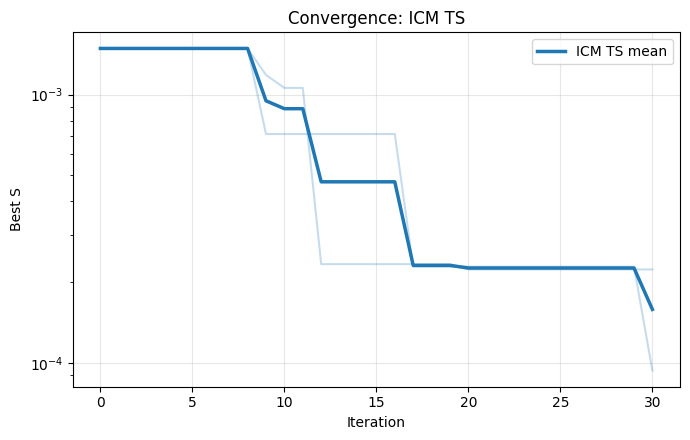

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

min_len = min(len(h) for h in icm_histories_raw_ts)
xs = np.arange(min_len)

plt.figure(figsize=(7, 4.5))

for h in icm_histories_raw_ts:
    plt.plot(xs, np.array(h[:min_len]), color="tab:blue", alpha=0.25)

icm_mean = np.mean([h[:min_len] for h in icm_histories_raw_ts], axis=0)
plt.plot(xs, icm_mean, label="ICM TS mean", color="tab:blue", linewidth=2.5)

plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Best S")
plt.title("Convergence: ICM TS")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()